<a id ='top'></a>

In [2]:
''' all necessary imports '''
from mesa.time import RandomActivation, SimultaneousActivation
from mesa.datacollection import DataCollector
from mesa import Agent, Model
from mesa.batchrunner import BatchRunner

import networkx as nx
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

<a id="top"> </id>
# Game Theory ABM


## Index:
 

* Functions to plot results
  - [Functions](#results_functions)


* Extending the model:
 - [Model Class](#n_Model)
 - [Agent Class](#n_Agent)
 - [Experiment 1](#n_experiment_1)
 - [Experiment 2](#n_experiment_2)
 - [Experiment 3](#n_experiment_3)


* Sensitivity analysis through Batch Runner 
 - [Test runs](#batch)
 
note: internal links may not work in Jupyter Lab


### Terminology:
Interactions:
- DI
>
>  Direct Interaction (each agents interact with his neighbourhood, one agent at a time. Each one decides whether or not to cooperate)
>
- WI 
>
> Witness Interaction (each agents asks his neighbourhood an opinion on an untrustworthy agents. Each neighbour decides whether or not to cooperate)
>

Agents:
- NA
>
> Naive agent, will always cooperate in DI, return a positive opinion of other agents in WI (thus sometimes cooperating other times not), will never drop anyone
>
- MA
>
> Malicious agent, will always defect in DI, return the opposite of his opinion in WI (always defecting also here, trying to fool), will never drop anyone
>
- TA
>
> Trust-aware agent, generally speaking he will always cooperate with agents who cooperate in DI, and will always cooperate in WI, returning his opinion. He will drop agents untrustworthy in DI
>
- TAplus
>
> As TA, but will drop also agents untrustworthy in WI
>

<a id ='results_functions'></a>
# Functions to Analyse results

Here we collect some functions we will use in the analysis phase to retrieve information from the df, build the graph, plot it and so on


[Back on top](#top)

In [3]:
def get_agent_type_ids(model, agent_type = "TA"):
    ''' Return the ids of agents of input type (e.g. ids of naive agents)'''
    
    return [agent.unique_id for agent in model.schedule.agents if agent.type == agent_type]


def get_all_agent_types_ids(model, agent_type_list = ["TA", "MA", "NA"]):
    ''' Returns a list of lists, each internal list will contain all ids of agents of a specified type.
        Calls get_agent_type_ids to get such lists. This function only serves the purpose of saving some lines of code'''

    lista = [get_agent_type_ids(model, agent_type) for agent_type in agent_type_list]
    return lista


def get_edge_list(model, step_num):
    ''' Return list with all the connections (at given step): [ [(i,j),(i,h),...,(i,k)], [(k,h)...] ]'''
    
    edge_list = [list(zip([a.unique_id]*len(a.neigh_evo[step_num]), a.neigh_evo[step_num])) for a in model.schedule.agents]
    return edge_list


def create_graph(edge_list, dict_ids_type):
    '''Create the graph from the edge_list and return it.
       Requires dict_ids_type, containing the color each agent's color'''
    
    # initialize the graph
    G = nx.Graph()
    G.clear()
    # create the edges and nodes from the list
    for i in range(len(edge_list)):
        G.add_edges_from(edge_list[i])
        
    # add an attribute to each node, containing its color
    for node in G.nodes():
        G.nodes[node]["col"] = dict_ids_type[node]
    return G


def graph_plot(G, pos, title,  width = 0.1):
    '''plot a colored graph, with input pos and edge_width'''
    
    node_color =  [G.nodes[i]["col"] for i in G.nodes()]
    nx.draw_networkx(G, pos=pos, with_labels=False, node_color=node_color, width = 0.1) # node_size=node_size 
    plt.axis('off')
    plt.title(title, fontsize=22, fontname='Arial')
    return


def which_steps(df, steps = [1,180,340]):
    '''Function that takes as input the BATCH AGENT df and a list of steps to look for.
       It adds n new columns (one for each step in the input list) to the BATCH agents df.
       Each row of these new columns contains the edges list of the agent at queried step.
       Returns a df'''
    
    df = df.sort_values(['Run','AgentId']) # Agent ids need sorting because it autosorts by Type (MA,NA,TA) since it is the only string
    
    for step in steps:
        edges_at_step = []

        for line in range(len(df)):
            
            # at every line gets the id and neigh list from the dictionary
            agent_id = df['AgentId'][line]          
            neigh_at_step = df['Neigh evo'][line][step]
            
            edges_at_step.append(list(zip([agent_id]*len(neigh_at_step), neigh_at_step)))

        # add column to df with edges at queried step    
        df['{}'.format(step)] = edges_at_step

    return df

# Extended Model

Most relevant changes happen in:
- ```request_connection()```
>
> Now, if an agent has the observer trait, he will only send connection requests to agents deemed trustworthy by his neighbourhood, to which is added a prior given by observed DI
>
- ```drop_connection()```
>
> TA+ will no longer drop Naive agents
>
- ```manage_connection_main()```
>
> If an agent has trait "Th" (Thoughtful) he will accept incoming requests if the requested is deemed trustworthy by his neighbourhood. If he has trait "Th+" (Enhanced Thouughtful), he will do the same as "Th" but only listening to the opinion of neighbours trustworthy in WI 
>
- ```ask_opinion()```
>
> New function
>
- ```direct_interaction_policy()```
>
> If an agent is an observer, he has a probability of observing others interact, based on his own willingness_to_observe
>


Note: due to the complexity added, the runs will take much longer, expecially with 200 agents

<a id ="n_Model"> </a>
## Model Class (Extended Model)

- [Back on top](#top)

In [4]:
class GameModel_extended(Model):
    """A model with some number of agents"""
    def __init__(self, N, TAplusp, TAp, MAp, NAp, d_alpha, w_alpha, d_beta, w_beta, omega, OMEGA, DT, heter_omegas, omegas_mean, omegas_var, *TAplus_TA_chars):  # heterogeneity,
        
        self.num_agents = N
        self.schedule = RandomActivation(self)    #RandomActivation  # SimultaneousActivation #BaseScheduler
        self.running = True  # puoi metterla False con una stopping condition, es stoppa quando gini diventa 0.5     
        
# Add Data Collector
        self.datacollector = DataCollector(
            model_reporters={"Avg_Neigh": avg_num_neighbours,
                             "avg_TA_wealth": avg_TA_wealth,
                             "avg_MA_wealth": avg_MA_wealth,
                             "avg_NA_wealth":avg_NA_wealth,
                             "Avg_TAp_wealth":avg_TAp_wealth,
                             "Avg_TA_neigh":avg_num_neighbours_TA,
                             "ACC_requests_TA":TA_acc_requests,
                             "Avg_TAp_neigh":avg_num_neighbours_TAplus,
                             "MA_in_TA_neigh":avg_MA_in_TA_neigh},
            
            agent_reporters={"Wealth": "wealth",
                             "Type":"type",
                             "MA_encoutered":"malicious_encountered",
                             "Num_Trust_values":"len_DI_dict"})

        # Get Agent quantities
        num_TAplus = int(TAplusp*self.num_agents)
        num_TA     = int(TAp*self.num_agents)
        num_MA     = int(MAp*self.num_agents)
        num_NA     = int(NAp*self.num_agents) # NAp is defined before model instance as 1-(percentages of other agents)
        
        # Define agents characteristics
        # If the keyword argument is specified, use the passed characteristics 
        try:
            #print(TAplus_TA_chars)
            TAplus_char = TAplus_TA_chars[1][0]
            print("TAplus_char = ", TAplus_char)
            TA_char     = TAplus_TA_chars[1][1]
            print("TA_char = ", TA_char)
        # otherwise, use standard characteristics.
        # By default, observer interactions aren't modelled
        except:
            TAplus_char = ['TAplus', 5, "TTFT", "Ho", "Mo", "Th+", 0] # type, ST, didr, answer policy, disconnection policy, connection type, will_to_obs
            TA_char     = ['TA', 5, "TTFT", "Ho", "Mo", "Th", 0]
        MA_char     = ['MA', 100, 'AD', "Li", "Le", "Ca", 0]
        NA_char     = ['NA', 15, 'AC', "Si", "Le", "Ca", 0]
        
        # Create Iterable of various Agents with Characteristics
        agents_chars = [TAplus_char]*num_TAplus+[TA_char]*num_TA+[MA_char]*num_MA+[NA_char]*num_NA #need them all in one line
        
        # Create agents
        for i, ch in enumerate(agents_chars):
            agent = GameAgent_extended(unique_id = i,
                          model= self,
                          d_alpha = d_alpha,
                          w_alpha = w_alpha,
                          d_beta = d_beta, 
                          w_beta = w_beta,
                          omega = omega,
                          OMEGA = OMEGA,
                          agent_type = ch[0],
                          ST_val = ch[1],
                          didr = ch[2],
                          answering_policy_type = ch[3],
                          disc_policy = ch[4],
                          DT = DT,
                          heter_omegas = heter_omegas,
                          conn_type = ch[5],
                          obs_willingness  = ch[6]
                        )
            self.schedule.add(agent)
            
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        
        
''' Data collector functions at Model level'''
# note: we use max() to avoid possible division by zero error

def avg_MA_in_TA_neigh(model):
    '''Get the avg number of MA connected to TA'''
    l = [[1 for MA in TA.neighbourhood if MA.type=='MA'] for TA in model.schedule.agents if TA.type=='TA']
    return sum([sum(l_) for l_ in l])/max(1,len(l))


def avg_num_neighbours_TA(model):
    '''Get the avg number of neighbours of TA'''
    lista = [len(agent.neighbourhood) for agent in model.schedule.agents if agent.type == "TA"]
    return sum(lista)/max(1,len(lista)) 
  
def avg_num_neighbours_TAplus(model):
    '''Get the avg number of neighbours of TA+'''
    lista = [len(agent.neighbourhood) for agent in model.schedule.agents if agent.type == "TAplus"]
    return sum(lista)/max(1,len(lista)) 

def avg_num_neighbours(model):
    '''Get the avg number of neighbours'''
    lista = [len(agent.neighbourhood) for agent in model.schedule.agents]
    return sum(lista)/max(1,len(lista))

def avg_TAp_wealth(model):
    '''Get the avg TA+ wealth increase at each step'''
    lista = [(agent.wealth - agent.prev_wealth)/max(1,len(agent.neighbourhood)) for agent in model.schedule.agents if agent.type == "TAplus"]
    return sum(lista)/max(1,len(lista))

def avg_TA_wealth(model):
    '''Get the avg TA wealth increase at each step'''
    lista = [(agent.wealth - agent.prev_wealth)/max(1,len(agent.neighbourhood)) for agent in model.schedule.agents if agent.type == "TA"]
    #print("wealth incr :", [(agent.wealth - agent.prev_wealth) for agent in model.schedule.agents if agent.type == "TA"])
    #print(sum(lista))
    return sum(lista)/max(1,len(lista))

def avg_MA_wealth(model):
    '''Get the avg MA wealth increase at each step'''
    lista = [(agent.wealth - agent.prev_wealth)/max(1,len(agent.neighbourhood)) for agent in model.schedule.agents if agent.type  == "MA"]
    return sum(lista)/max(1,len(lista))

def avg_NA_wealth(model):
    '''Get the avg NA wealth increase at each step'''
    lista = [(agent.wealth - agent.prev_wealth)/max(1,len(agent.neighbourhood)) for agent in model.schedule.agents if agent.type  == "NA"]
    return sum(lista)/max(1,len(lista))

def TA_acc_requests(model):
    '''Get the number of accepted requests by TA, towards agent that aren't malicious 
     note: this isdue to how accepted_requests_count is incremented'''
    lista = [agent.accepted_requests_count for agent in model.schedule.agents if agent.type == "TA"]
    return sum(lista)

<a id ="Agent"> </a>
# Agent Class  (Extended Model)

- [Back on top](#top)

In [5]:
class GameAgent_extended(Agent):
        
    def __init__(self, 
                 unique_id,
                 model, 
                 d_alpha = .1, 
                 w_alpha = .1,
                 d_beta = -.1, 
                 w_beta = -.1,
                 omega = .9,
                 OMEGA = -.9,
                 agent_type = "TA",
                 ST_val = 5,
                 didr = "TTFT",
                 answering_policy_type = "Ho",
                 disc_policy = "Mo",
                 DT = 0.25,
                 heter_omegas = True,
                 omegas_mean = 0.5,
                 omegas_var  = 0.4,
                 conn_type = "Ca",
                 obs_willingness = 0): # added connection type
        
        super().__init__(unique_id, model)
        self.neighbourhood           = set()
        self.blacklist               = []
        self.visited                 = {self} #set which contains self instance, so an agent doesn't append itself to neighbour list
        self.last_interaction        = {}
        self.connection_list         = []
        self.already_interacted_list = []
        self.wealth_list             = []
        self.others_trustworthyness  = {}  
        self.direct_trust_dict       = {} #{agent_instance : 0 for agent_instance in self.model.schedule.agents}  # each agent starts with a DI trust value of 0
        self.witness_trust_dict      = {} #{agent_instance : 0 for agent_instance in self.model.schedule.agents}  # each agent starts with a WI trust value of 0
        self.neigh_evo               = {}
        
        self.d_alpha = d_alpha   # needs to be > 0 
        self.w_alpha = w_alpha   # needs to be > 0
        
        self.d_beta  = d_beta    # needs to be < 0 
        self.w_beta  = w_beta    # needs to be < 0 
        
        if heter_omegas == True:
            # Initialize omegas just to enter the while loop
            self.omega = 0
            self.OMEGA = 1
            while self.omega < self.OMEGA or self.OMEGA <= -1 or self.omega >= 1:
                # omegas according to a normal distribution
                self.omega = np.random.normal(omegas_mean, omegas_var, 1)
                self.OMEGA = np.random.normal(-omegas_mean, omegas_var, 1)   
            
        else:
            self.omega   = omega
            self.OMEGA   = OMEGA
            
        self.ST      = ST_val          # three values:  Conservative (C) = 5; Naive (N) = 15, Greedy (G) = 100
        self.prev_wealth = 0
        self.wealth      = 0
        self.avg_utility = 0
        self.count       = 0
        
        self.type                  = agent_type
        self.didr                  = didr        # didr= DI decision-rule; "AC", "AD", TTFT"
        self.conn_type             = conn_type   # "Thougtful" will ask for neigh opinion before accepting connect. request, "Careless" will always connect
        self.will_to_obs           = obs_willingness
        self.answering_policy_type = answering_policy_type  # Ho, Li, Si
        self.disc_policy           = disc_policy # Le, Mo, St
        self.DT                    = DT   # Discrimination Threshold, set to 0.25 in the paper
        
        #self.charisma = (random.random() < 0.1 and self.type == 'MA')
        self.all_time_blacklist = set()
        
        self.malicious_encountered = 0
        self.len_DI_dict = 0
        self.accepted_requests_count = 0
        
#######################################################################################    
#                         Manage Connections                                          #
#######################################################################################       
    
    def request_connection(self, target_agent):
        '''Send a connection request to the target agent (sends the object of self)'''
        
        # if self is an observer, only send connection request if the randomly drawn agent seems trustworthy
        if self.will_to_obs > 0:
            reputation = self.ask_opinion(target_agent)
            if reputation > self.omega:
                target_agent.connection_list.append(self)
                
                if target_agent.type == "MA":
                    print("\nObserver sent request to a MA! ", self.type, reputation)

        # if self isn't an observer, he will send a connection request to any randomly drawn agent       
        else:
            target_agent.connection_list.append(self)
        return
    
    
    def connect_to(self, target_agent):
        '''Accept a connection request, then consider each agent as 'visited' in each other's POV, updating the appropriate lists'''
            
# Accept pending friend request, storing the relative agent object in the appropriate list
        self.neighbourhood.add(target_agent)  
        target_agent.neighbourhood.add(self)  
        
# Initialize the trust-values to zero
        self.direct_trust_dict[target_agent]  = 0
        self.witness_trust_dict[target_agent] = 0
        target_agent.direct_trust_dict[self]  = 0
        target_agent.witness_trust_dict[self] = 0
        
# Take care of malicious_encountered count
        if target_agent.type == "MA":
            if self.type == "TA+":
                print("yo1")
            self.malicious_encountered += 1
        if target_agent.type == "MA":
            if self.type == "TA+":
                print("yo1")
            target_agent.malicious_encountered += 1
        if self.type == "TA" and target_agent.type != "MA":
            self.accepted_requests_count += 1
        return
     
        
    def drop_connection(self):
        '''Drop connection with agents deemed untrustworthy, based on the agent policy '''
        
# if there are agents untrustworthy in terms of Direct Interactions pick one of them
# Note: TAplus will no longer add to this list agents untrustworthy in WI
        self.blacklist = [agent for agent in self.neighbourhood if self.direct_trust_dict[agent] <= self.OMEGA] 
        if len(self.blacklist) > 0:
            target_agent = random.choice(self.blacklist)

# drop this user randomly selected from untrustworthy ones, if the disconnection policy lets the agent do so.
# everyone but "Lenient" agents disconnect if untrustworthy 
            if self.disc_policy != "Le": 
        
                self.neighbourhood.remove(target_agent)  # remove the agent from self's neighbours
                target_agent.neighbourhood.remove(self)  # remove self from agent's neighbours  
                
                # it may happen that 2 agents want to remove each other, but if A goes first, than B
                # will try to remove A, who is no longer in the neighbourhood already. Updating B's
                # blacklist solves this 
               # try:
               #     target_agent.blacklist.remove(self)      
                #except:
                #    pass  
        return
 
    def manage_connection_main(self):
        '''Call connect_to (in other words, accept a pending friend request) using FIFO.
           Call request_connection towards a random unvisited agent, if the set cardinality hasn't been reached yet
           Call drop_connection to eventually drop a connection based on agent policy '''
        
        # just for stats
        self.accepted_requests_count = 0 
# Datacollector gave problems collecting neighbourhoods, we created our reporter
        neigh_ids = [agent.unique_id for agent in self.neighbourhood]
        self.neigh_evo.update({self.count:neigh_ids}) # self.count = step
        self.count +=1
        self.len_DI_dict = len(self.direct_trust_dict)
        
# Eventually drop a connection based on agent policy
        self.drop_connection()
            
# connect to any agent who asked for a connection, unless self is "Thoughtful"
        if len(self.connection_list) > 0 :
            # extract the first agent from the list
            agent_to_connect = self.connection_list.pop(0) 
            
            # connect if self isn't "Thoughtful"
            if self.conn_type != "Th" and self.conn_type != "Th+":       
                self.connect_to(agent_to_connect)       
                
            else:              
                # gain a reputation score of that agent from neighbours (+ prior if self is an observer)
                reputation = self.ask_opinion(agent_to_connect)

                # if the agent seems to be untrustworthy, avoid him
                if reputation < self.OMEGA:
                    pass

                # if he seems to be trustworthy, add him (potentially add him also based on a coin-flip)
                elif reputation > self.omega: # or random.random() < 0.10
                    
                    if agent_to_connect.type == "MA" and self.type =="TA+":
                        print("\nObserver accepted a request from an MA! ", self.type, reputation, "omega =", self.omega)
                    agent_to_connect.connection_list.append(self)
                    self.connect_to(agent_to_connect)

                # if he's unknown, add him to the end of the list, so check again for him in a while
                else:
                    self.connection_list.append(agent_to_connect)
                     
# Request a connection to a random unvisited agent, if neighbour list not full yet (and if we haven't already visited all)
        
        if len(self.neighbourhood) <  self.ST and len(self.model.schedule.agents) > len(self.visited):   
        
            # below we cast agent_list to set, so we can use "difference", then we cast the returned set to tuple to use random.choice
            target_agent = random.choice(list(set(self.model.schedule.agents).difference(self.visited))) 
        
            self.request_connection(target_agent)
            
            # This will avoid spamming
            self.visited.add(target_agent)  # self visited target_agent (won't ask him again for a connection)
            target_agent.visited.add(self)  # target_agent visited self (won't ask him for a connection)
    
        return
    
    def ask_opinion(self, agent_to_connect):
        '''Return the reputation of an agent, given by the average opinion of the agents,
           plus an eventual prior if self is an Observer.
           If self is "Th+", only take into account the opinion of neighbours trustworthy in WI '''
        
        opinion_list = []
        for neighbour in self.neighbourhood:
            
            #Th+ agents take into considerations only opinions of agents trustworthy in WI
            if self.conn_type == "Th+" and self.witness_trust_dict[neighbour] < self.omega:
                # skip this neighbour
                continue
            
            # it actually can happen if omega is hetereogeneous and can take value less than 0
            #if self.witness_trust_dict[neighbour] == 0 and self.conn_type == "Th+":
            #    print("this shouldn't happen")

            try:
                curr_trust = neighbour.direct_trust_dict[agent_j] 
            except:
                curr_trust = 0 # set to 0 if the neighbour hasn't encountered agent_j yet

            possible_opinions = {"Ho" : curr_trust,       # honest
                                 "Li" : -1 * curr_trust,  # liar
                                 "Si" : 1}                # simpleton
            
            opinion = possible_opinions[neighbour.answering_policy_type]
            opinion_list.append(opinion)
            
        reputation = sum(opinion_list)/max(1,len(opinion_list))
            
        # if self is an Observer add a prior (if any) to the agent reputation
        if self.will_to_obs > 0:
            try:             
                reputation +=  self.direct_trust_dict[agent_to_connect]
            except:
                pass
        
        return reputation
        

#######################################################################################    
#                             Direct interactions                                     #
#######################################################################################                
                
    def direct_trust_update(self, agent_pov, target_agent, cooperated, observing = False):
        '''Update DI trust value based on whether the other agent cooperated in the latest interaction'''
                       
        # implementing the formula on page 5 of the paper
        try:
            curr_trust = agent_pov.direct_trust_dict[target_agent] 
        except:
            agent_pov.direct_trust_dict[target_agent] = 0
            curr_trust = 0
            
        if curr_trust < 0:
            if cooperated == True:  # curr_trust < 0 and cooperated 
                agent_pov.direct_trust_dict[target_agent] = (curr_trust + agent_pov.d_alpha)/(1-min(abs(curr_trust),abs(agent_pov.d_alpha)))
            else:                   # curr_trust < 0 and defected 
                agent_pov.direct_trust_dict[target_agent] += agent_pov.d_beta  * (1+curr_trust) 
        else: 
            if cooperated == True:  # curr_trust > 0 and cooperated
                agent_pov.direct_trust_dict[target_agent] += agent_pov.d_alpha * (1-curr_trust) 
            else:                   # curr_trust > 0 and defected 
                agent_pov.direct_trust_dict[target_agent] = (curr_trust + agent_pov.d_beta)/(1-min(abs(curr_trust),abs(agent_pov.d_beta)))
        return
    
    def direct_interaction_decision_rule(self, agent_pov, target_agent):
        '''Decide whether or not to cooperate in a DI. return True if cooperated, False if defected.
           Note: it is general, so may be used both by self and another agent, hence agent_pov'''
             
        if agent_pov.didr == "AC":      # AC -> cooperate
            return True 
        
        elif agent_pov.didr == "AD":    # AD -> defect
            return False

        elif agent_pov.didr == "TTFT":  # TTFT -> if agent_j not known: cooperate, then imitate; elif agent_j trustworthy: cooperate, elif agent_j untrustworthy: defect   
                        
            if agent_pov.OMEGA < agent_pov.direct_trust_dict[target_agent] <= agent_pov.omega: # if not known yet
                try:
                    return agent_pov.last_interaction[target_agent]   # imitate the other's last interaction, if any
                except:
                    return True                                  # if the two haven't interacted, just cooperate
            elif agent_pov.direct_trust_dict[target_agent] <= agent_pov.OMEGA:                 # if the interacting agent is untrustworthy
                return False                                     # defect 
            else:                                                                              # if the interacting agent is trustworthy  
                return True                                      # cooperate                                  
     
    def direct_interaction_policy(self):
        '''Manage direct interactions'''
                
# save prev wealth value, useful for statistics
        self.prev_wealth = self.wealth
        # increase wealth from interactions already played out
        self.wealth += sum(self.wealth_list)
        self.wealth_list.clear()
        # not needed, but may help with readability
        self_pov = self
        
# interact with all agents in the neighbourhood with whom self hasn't interacted yet in this step
        for neighbour in self_pov.neighbourhood.difference(self_pov.already_interacted_list): 
            
             # draw an observer
            observer_list = list(set([agent for agent in self.model.schedule.agents if agent.will_to_obs >= random.random()]).difference({self_pov,neighbour}))
            
# Play out the interaction
            # True if the agent decides to cooperate
            self_pov_cooperate = self.direct_interaction_decision_rule(agent_pov = self_pov, target_agent = neighbour)
            # True if the neighbour decides to cooperate
            neighbour_pov_cooperate = self.direct_interaction_decision_rule(agent_pov = neighbour, target_agent = self) 
            
# update the agents utility based on the payoff matrix. 
            # Note: to avoid confounding with prev_wealth and wealth coming from this step,
            # we mustn't increase the wealth of neighbours directly in this step.
            # Instead we will append it to a list and let them gain that wealth on their turn
            if self_pov_cooperate == True:    
                if neighbour_pov_cooperate == True: # both cooperated
                    self.wealth += 3
                    neighbour.wealth_list.append(3)
                else:                               # self cooperated and neigh defected
                    neighbour.wealth_list.append(5)
            else:                           
                if neighbour_pov_cooperate == True: # self defected and neigh cooperated
                    self.wealth += 5
                else:                               # both defected
                    self.wealth += 1
                    neighbour.wealth_list.append(1)
            
# update trust values
            # update self DIT value, based on whether the neigh cooperated
            self.direct_trust_update(self_pov, neighbour, neighbour_pov_cooperate)
            # update neighbour DIT value, based on whether self cooperated
            self.direct_trust_update(neighbour, self_pov, self_pov_cooperate)
            
# update trust values for the observer
            for observer in observer_list:
                
                # unsilence only if toy model with few agents and time steps
                #print(observer.unique_id, " observing: ", neighbour.unique_id, self.unique_id)

                self.direct_trust_update(observer, neighbour, neighbour_pov_cooperate, observing = True)
                self.direct_trust_update(observer, self_pov, self_pov_cooperate, observing = True)

# record the last interaction of the other agent (needed for some decision rules)
            self.last_interaction[neighbour] = neighbour_pov_cooperate
            neighbour.last_interaction[self_pov] = self_pov_cooperate
               
# append self to neighbour's already_interacted_list to avoid interacting again in this step
            neighbour.already_interacted_list.append(self)
                        
# reset the already interacted list, so that next step self will interact again with all his neighbourhood
        self.already_interacted_list.clear()
        return
                     
            
#######################################################################################    
#                               Witness interactions                                  #
#######################################################################################


    def witness_trust_update(self, target_agent, cooperated):
        ''' Update WI trust value for neighbours '''
        
        #print("other's type = ", target_agent.type, "cooperated = ", cooperated)
        
        curr_trust = self.witness_trust_dict[target_agent]  
        if curr_trust < 0:
            if cooperated == True:
                self.witness_trust_dict[target_agent] = (curr_trust + self.w_alpha)/(1-min(abs(curr_trust),abs(self.w_alpha)))
            else:  # curr_trust < 0 and defected 
                self.witness_trust_dict[target_agent] += self.w_beta  * (1+curr_trust) 
        else: # curr_trust > 0
            if cooperated == True:
                self.witness_trust_dict[target_agent] += self.w_alpha * (1-curr_trust) 
            else: # curr_trust > 0 and defected 
                self.witness_trust_dict[target_agent] = (curr_trust + self.w_beta)/(1-min(abs(curr_trust),abs(self.w_beta)))
        return
                    
    def answering_policy(self, neighbour, agent_j):
        ''' The neighbour decides whether or not to cooperate in a WI.
            Collaboration -> neighbour gives an opinion close to what he really thinks of agent-j, returning True '''

# retrieve the current DI trust value of the agent towards agent_j
        try:
            curr_trust = neighbour.direct_trust_dict[agent_j] 
        except:
            curr_trust = 0 # set to 0 if the neighbour hasn't encountered agent_j yet
            
        possible_opinions = {"Ho" : curr_trust,       # honest
                             "Li" : -1 * curr_trust,  # liar
                             "Si" : 1}                # simpleton
        
        opinion = possible_opinions[neighbour.answering_policy_type]
        
# if the opinion given by the answering agent isn't far from what he really thinks, return a collaboration, otherwise a defection
        if abs(opinion - curr_trust) < self.DT:
            return True
        else: 
            return False
        
    def querying_policy(self):
        '''Create the blacklist, with agents untrustworthy in DI (or also in WI if agent is TAplus).
           If any, call answering_policy to ask the neighbours what they think of one of them,
           then update the WI trust value based on whether they cooperated or not.
        '''
                 
# create the blacklist based on latest info, will be used to drop untrusttworthy agents and 
# to interrogate neighbours on encountered agents untrustworthy in DI   
        self.blacklist = [agent for agent in self.neighbourhood if self.direct_trust_dict[agent] <= self.OMEGA] 
    
# update a set with all the agents blacklisted by self, so interrogations may continue after having dropped all MA from the neighbourhood 
        self.all_time_blacklist.update(self.all_time_blacklist.union(set(self.blacklist)))
        
# Only agents with "ST" policy will make use of WI, so just return in other cases.  
# Also, if the agent hasn't ever put anyone in the blacklist, just return
        if self.disc_policy != "St" or not self.all_time_blacklist and not self.blacklist:
            return

# if there are agents in the blacklist, pick one of them
        if self.blacklist:
            agent_j = random.choice(self.blacklist)            
# otherwise, pick one who is no longer in the neighbourhood but was known to be untrustworthy
        elif self.all_time_blacklist:
            agent_j = random.choice(list(self.all_time_blacklist) )
            
# for each neighbour: ask for their opinion on agent_j, update WI trust value based on whether thei cooperated or not 
        for neighbour in self.neighbourhood:
            answer = self.answering_policy(neighbour, agent_j) 
            self.witness_trust_update(target_agent = neighbour, cooperated = answer) 
    
        return

        
#######################################################################################    
#                                      Steps                                          #
#######################################################################################        
            
    def step(self):
        self.manage_connection_main()     # connect and/or disconnect from neighbours
        self.direct_interaction_policy()  # interact and update DI trust values
        self.querying_policy()            # create blacklist, do WI interactions and update WI trust values

<a id="n_experiment_1"> </a>
# Experiment 1

TA_perc = 0.66, the rest are Malicious, as in Experiment 1 from the paper.


**TA now will ask neighbours opinion before accepting incoming friend requests. Will this help or deceive TA in isolating themselves from MA?**



- [Back on top](#top)
- [Back to functions to plot results](#results_functions)

In [22]:
''' MODEL PARAMETERS '''
N = 200   # num agents
N_steps = 400 # num steps

# agent type distribution
TAplus_perc = 0     # % of Trust-Aware-plus we want
TA_perc     = 0.66  # % of Trust-Aware we want
MA_perc     = 0.34  # % of Malicious we want
NA_perc     = 1 - MA_perc - TA_perc - TAplus_perc    # % of Naive we want

''' AGENT PARAMETERS '''
alpha_vals = [0.2, 0.2]       # values of alpha for DI and WI (must be > 0)
beta_vals  = [-0.3, -0.3]     # values of beta for DI and WI  (must be < 0)
DT = 0.25                     # threshold relevant for WI decision rule, set to 0.25 in the paper

heter_omegas = True
omegas_mean  = 0.3
omegas_var   = 0.5

# doesn't do anything if heter_omegas = True
omega_vals = [0.6, -0.6]      # values of omega (upper threshold; between -1 and 1) and OMEGA (between -1 and 1; if DI trust > omega, agent is considered trustworthy)


''' RUN THE MODEL '''

model = GameModel_extended(N,                                     # <--- intitialize the model
                  TAplus_perc, TA_perc, MA_perc, NA_perc,
                  alpha_vals[0], alpha_vals[1],
                  beta_vals[0], beta_vals[1],
                  omega_vals[0], omega_vals[1],     # doesn't do anything if heter_omegas = True
                  DT,
                  heter_omegas, omegas_mean, omegas_var    
                 ) 

for i in range(N_steps):                                 # <--- Run the model for N_steps steps
    model.step()

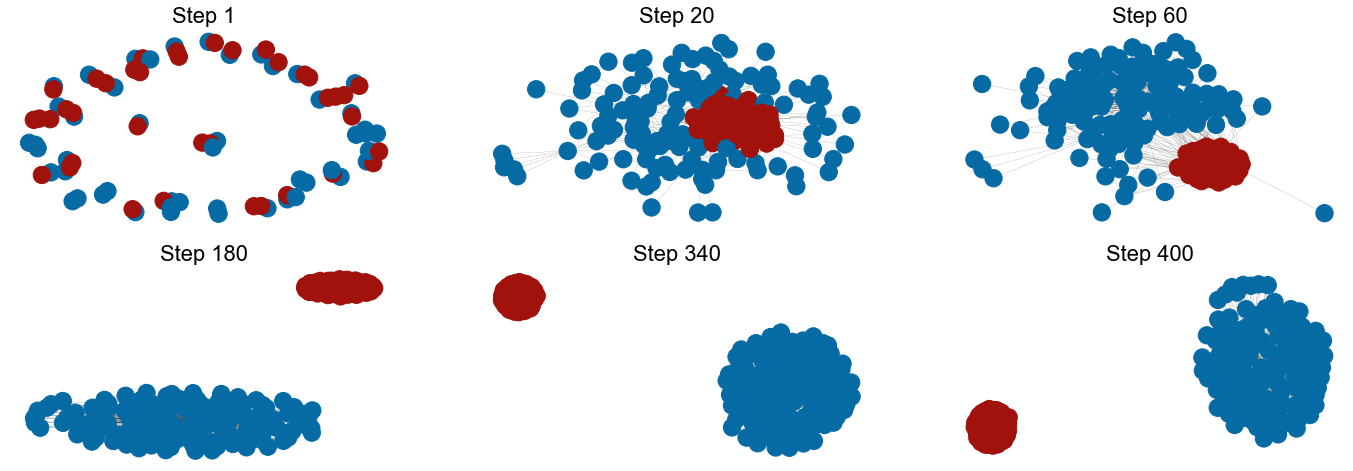

In [23]:
# create the df with all the collected agent-level variables
agent_df = model.datacollector.get_agent_vars_dataframe().xs(0, level='Step')['Type']

''' associate each agent_type to a color '''
dict_ids_type = {agent_df.index[i]:('#A0120B' if agent_df[i]=="MA" else '#068708' if agent_df[i]=="NA" else '#066BA5') for i in range(len(agent_df))}

''' creating lists with all the connections (at given step): [ [(nodei,nodej),(nodei,nodeh)...], [(nodej,nodeh)...] ]'''
edge_list_1 = get_edge_list(model, step_num = 1)
edge_list_2 = get_edge_list(model, step_num = 20)
edge_list_3 = get_edge_list(model, step_num = 60)
edge_list_4 = get_edge_list(model, step_num = 180)
edge_list_5 = get_edge_list(model, step_num = 340)
edge_list_6 = get_edge_list(model, step_num = N_steps-1)

''' creating graphs '''
G1 = create_graph(edge_list_1, dict_ids_type)
G2 = create_graph(edge_list_2, dict_ids_type)
G3 = create_graph(edge_list_3, dict_ids_type)
G4 = create_graph(edge_list_4, dict_ids_type)
G5 = create_graph(edge_list_5, dict_ids_type)
G6 = create_graph(edge_list_6, dict_ids_type)
    
''' plotting graphs '''
matplotlib.rcParams['figure.figsize']= [24, 8]

# create the pos relative to each Graph
pos1 = nx.spring_layout(G1)  # fruchterman_reingold_layout, kamada_kawai_layout, spring_layout
pos2 = nx.spring_layout(G2) 
pos3 = nx.spring_layout(G3) 
pos4 = nx.spring_layout(G4) 
pos5 = nx.spring_layout(G5) 
pos6 = nx.spring_layout(G6) 

# plot each Graph
plt.subplot(231)
graph_plot(G1, pos1, title="Step 1",  width = 0.1)
plt.subplot(232)
graph_plot(G2, pos2, title="Step 20", width = 0.1)
plt.subplot(233)
graph_plot(G3, pos3, title="Step 60", width = 0.1)
plt.subplot(234)
graph_plot(G4, pos4, title="Step 180", width = 0.1)
plt.subplot(235)
graph_plot(G5, pos5, title="Step 340", width = 0.1)
plt.subplot(236)
graph_plot(G6, pos6, title="Step 400", width = 0.1)

In [24]:
''' neighbourhood length by agent type '''
n = [(len(agent.neighbourhood), agent.type) for agent in model.schedule.agents]
n
# some TA have an extreme number of their peers in the neighbourhood, some others have less than 5

[(0, 'TA'),
 (6, 'TA'),
 (5, 'TA'),
 (7, 'TA'),
 (0, 'TA'),
 (5, 'TA'),
 (5, 'TA'),
 (51, 'TA'),
 (6, 'TA'),
 (5, 'TA'),
 (7, 'TA'),
 (6, 'TA'),
 (6, 'TA'),
 (6, 'TA'),
 (44, 'TA'),
 (7, 'TA'),
 (7, 'TA'),
 (6, 'TA'),
 (6, 'TA'),
 (5, 'TA'),
 (6, 'TA'),
 (6, 'TA'),
 (5, 'TA'),
 (47, 'TA'),
 (6, 'TA'),
 (7, 'TA'),
 (6, 'TA'),
 (6, 'TA'),
 (5, 'TA'),
 (5, 'TA'),
 (6, 'TA'),
 (56, 'TA'),
 (9, 'TA'),
 (4, 'TA'),
 (6, 'TA'),
 (7, 'TA'),
 (4, 'TA'),
 (6, 'TA'),
 (6, 'TA'),
 (7, 'TA'),
 (5, 'TA'),
 (42, 'TA'),
 (5, 'TA'),
 (5, 'TA'),
 (44, 'TA'),
 (5, 'TA'),
 (4, 'TA'),
 (6, 'TA'),
 (7, 'TA'),
 (5, 'TA'),
 (4, 'TA'),
 (0, 'TA'),
 (5, 'TA'),
 (6, 'TA'),
 (4, 'TA'),
 (7, 'TA'),
 (5, 'TA'),
 (5, 'TA'),
 (5, 'TA'),
 (5, 'TA'),
 (5, 'TA'),
 (6, 'TA'),
 (6, 'TA'),
 (46, 'TA'),
 (6, 'TA'),
 (7, 'TA'),
 (5, 'TA'),
 (5, 'TA'),
 (4, 'TA'),
 (53, 'TA'),
 (60, 'TA'),
 (44, 'TA'),
 (8, 'TA'),
 (6, 'TA'),
 (6, 'TA'),
 (5, 'TA'),
 (7, 'TA'),
 (7, 'TA'),
 (6, 'TA'),
 (5, 'TA'),
 (6, 'TA'),
 (6, 'TA'),
 (5, '

In [25]:
''' Get the average number of MA encountered by each agent_type '''
agent_df = model.datacollector.get_agent_vars_dataframe()
agent_df['Num_Agents'] = 1
num_agents = agent_df.xs(N_steps-1, level="Step").groupby("Type").sum()["Num_Agents"].tolist()
agent_df.xs(N_steps-1, level="Step").groupby("Type").sum()/[1,num_agents,num_agents,1]

# we average also Num_Trust_values, which allows to get an idea of how many other agents each
# agent type visited

,Wealth,MA_encoutered,Num_Trust_values,Num_Agents
Type,,,,
MA,1598989.0,67.000000,120.058824,68.0
TA,1379741.0,34.287879,39.500000,132.0


In [26]:
''' num TA with omega < 0 (super-trusters, they will consider new agents as Trustworthy) '''
n = [agent.omega for agent in model.schedule.agents if agent.type == "TA" and agent.omega < 0]
print("there are {} super-trusters in this run, on 132 TA".format(len(n)))

there are 14 super-trusters in this run, on 132 TA


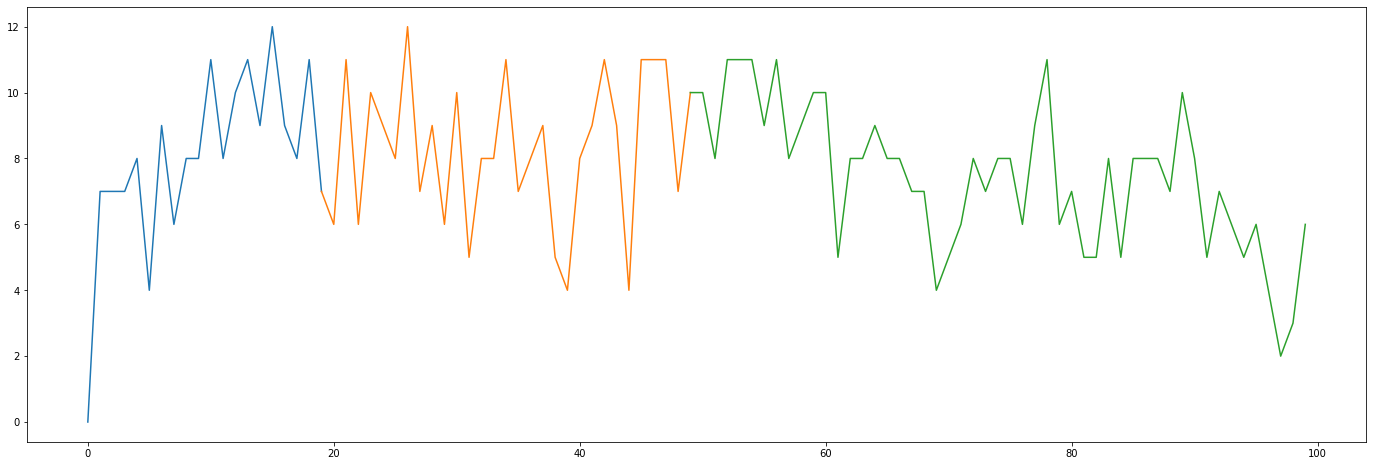

In [27]:
'''plot the average connection requests accepted by TA agents per step'''
model_df = model.datacollector.get_model_vars_dataframe()
model_df["ACC_requests_TA"][:20].plot()
model_df["ACC_requests_TA"][19:50].plot()
model_df["ACC_requests_TA"][49:100].plot()

    We can see from this plot  the avg number of accepted connection requests by TA towards other TA. 
    It stands around 10 and never surpasses 14, close to the number of super-trusters.
    The variability is due to the fact that not at every step a super-truster may receive a connection request. 
    Furthermore, from around step 80 the mean number of connection requests accepted slowly starts decreasing, because as TA start accepting other TAs thanks to super-trusters, the number of connection requests sent by TA will gradually decrease

**Comment**:

    TA win condition: fill their neighbourhoods mostly with other TAs, so they will avoid adding MA, taking advantage of each other's experience and trustworthyness.
    
    TA will send connection requests, but won't accept them unless the agent is reccomended by neighbours; this means that, unless there are super-trusters, TA will never accept other TAs because they will fill their neighbourhoods with MAs, who will always avoid reccomending other TAs, so in the final state TAs will not have any connection. Thus, an apparently more rational behavour at individual level can lead to a disadvantage when the aggregate interactions play out. 
    Furthermore, this stresses the importance of agents who tend to be trust unknown agents. While they can be exploited, they will also help bring together communities, thanks to their direct experience

---
### Experiment 2

TA = 55%, MA = 34%, NA = 11%



**TA now will ask neighbours opinion before accepting incoming friend requests. Will this help or deceive TA in isolating themselves from MA when also NA are present?**



- [Back on top](#top)
- [Back to functions to plot results](#results_functions)

In [28]:
''' MODEL PARAMETERS '''
N = 200       # num agents
N_steps = 400 # num steps

# agent type distribution
TAplus_perc = 0     # % of Trust-Aware-plus we want
TA_perc     = 0.55  # % of Trust-Aware we want
MA_perc     = 0.34 # % of Malicious we want
NA_perc     = 1 - MA_perc - TA_perc - TAplus_perc    # % of Naive we want

''' AGENT PARAMETERS '''
alpha_vals = [0.2, 0.2]       # values of alpha for DI and WI (must be > 0)
beta_vals  = [-0.3, -0.3]     # values of beta for DI and WI  (must be < 0)
DT = 0.25                     # threshold relevant for WI decision rule, set to 0.25 in the paper

heter_omegas = True
omegas_mean  = 0.3
omegas_var   = 0.5

# doesn't do anything if heter_omegas = True
omega_vals = [0.6, -0.6]      # values of omega (upper threshold; between -1 and 1) and OMEGA (between -1 and 1; if DI trust > omega, agent is considered trustworthy)

''' RUN THE MODEL '''
model = GameModel_extended(N,                                     # <--- intitialize the model
                  TAplus_perc, TA_perc, MA_perc, NA_perc,
                  alpha_vals[0], alpha_vals[1],
                  beta_vals[0], beta_vals[1],
                  omega_vals[0], omega_vals[1],    # doesn't do anything if heter_omegas = True
                  DT,
                  heter_omegas, omegas_mean, omegas_var    
                  #heterogeneity=False
                 ) 
for i in range(N_steps):                                 # <--- Run the model for N_steps steps
    model.step()

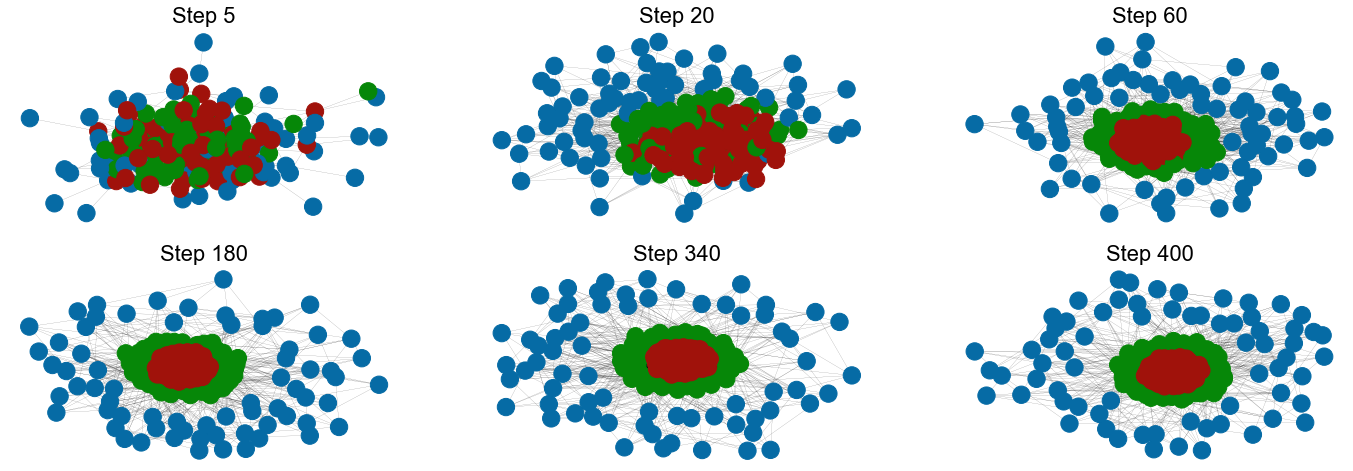

In [29]:
# create the df with all the collected agent-level variables
agent_df = model.datacollector.get_agent_vars_dataframe().xs(0, level='Step')['Type']

''' associate each agent_type to a color '''
dict_ids_type = {agent_df.index[i]:('#A0120B' if agent_df[i]=="MA" else '#068708' if agent_df[i]=="NA" else '#066BA5') for i in range(len(agent_df))}

''' creating lists with all the connections (at given step): [ [(nodei,nodej),(nodei,nodeh)...], [(nodej,nodeh)...] ]'''
edge_list_1 = get_edge_list(model, step_num = 5)
edge_list_2 = get_edge_list(model, step_num = 20)
edge_list_3 = get_edge_list(model, step_num = 60)
edge_list_4 = get_edge_list(model, step_num = 180)
edge_list_5 = get_edge_list(model, step_num = 340)
edge_list_6 = get_edge_list(model, step_num = N_steps-1)

''' creating graphs '''
G1 = create_graph(edge_list_1, dict_ids_type)
G2 = create_graph(edge_list_2, dict_ids_type)
G3 = create_graph(edge_list_3, dict_ids_type)
G4 = create_graph(edge_list_4, dict_ids_type)
G5 = create_graph(edge_list_5, dict_ids_type)
G6 = create_graph(edge_list_6, dict_ids_type)
    
''' plotting graphs '''
matplotlib.rcParams['figure.figsize']= [24, 8]

# create the pos relative to each Graph
pos1 = nx.spring_layout(G1)  # fruchterman_reingold_layout, kamada_kawai_layout, spring_layout
pos2 = nx.spring_layout(G2) 
pos3 = nx.spring_layout(G3) 
pos4 = nx.spring_layout(G4) 
pos5 = nx.spring_layout(G5) 
pos6 = nx.spring_layout(G6) 

# plot each Graph
plt.subplot(231)
graph_plot(G1, pos1, title="Step 5",  width = 0.1)
plt.subplot(232)
graph_plot(G2, pos2, title="Step 20", width = 0.1)
plt.subplot(233)
graph_plot(G3, pos3, title="Step 60", width = 0.1)
plt.subplot(234)
graph_plot(G4, pos4, title="Step 180", width = 0.1)
plt.subplot(235)
graph_plot(G5, pos5, title="Step 340", width = 0.1)
plt.subplot(236)
graph_plot(G6, pos6, title="Step "+str(N_steps), width = 0.1)

In [30]:
''' Get the average number of MA encountered by each agent_type '''
agent_df = model.datacollector.get_agent_vars_dataframe()
agent_df['Num_Agents'] = 1
num_agents = agent_df.xs(N_steps-1, level="Step").groupby("Type").sum()["Num_Agents"].tolist()
agent_df.xs(N_steps-1, level="Step").groupby("Type").sum()/[1,num_agents,num_agents,1]

# we average also Num_Trust_values, which allows to get an idea of how many other agents each
# agent type visited

,Wealth,MA_encoutered,Num_Trust_values,Num_Agents
Type,,,,
MA,6308487.0,57.060606,128.666667,66.0
NA,912993.0,44.292308,56.461538,65.0
TA,646361.0,51.382353,36.264706,68.0


    There are two forces at play: MA will try to fill themselves into TAs neighbourhoods, by reccomending other MAs while not reccomending TAs and NAs; on the other hand, NA will act ad 'bridges', reccomending anyone, thus also other TAs.  TA may may never reach an equilibrium if they have some NA in their neighbourhood, as they might accept a Malicious agent even in the long run. This last factor is enhanced by the fact that TAs also need to have interacted with other TAs in order to be able to reccomend them, so it isn't easy for TA to connect with their peers    

<a id="n_experiment_3"> </a>
# Experiment 3

**TA as before, while TAplus will send requests to any agent, but will only accept ones reccomended by neighbours *trustworthy* in WI**


- [Back on top](#top)

In [31]:
''' MODEL PARAMETERS '''
N = 200       # num agents
N_steps = 800 # num steps

# agent type distribution
TAplus_perc = 0.15     # % of Trust-Aware-plus we want
TA_perc     = 0.15  # % of Trust-Aware we want
MA_perc     = 0.50 # % of Malicious we want
NA_perc     = 1 - MA_perc - TA_perc - TAplus_perc    # % of Naive we want

''' AGENT PARAMETERS '''
alpha_vals = [0.2, 0.2]      # values of alpha for DI and WI (must be > 0)
beta_vals  = [-0.3, -0.3]     # values of beta for DI and WI  (must be < 0)
DT = 0.25                     # threshold relevant for WI decision rule, set to 0.25 in the paper

heter_omegas = True
omegas_mean  = 0.3
omegas_var   = 0.5

# doesn't do anything if heter_omegas = True
omega_vals = [0.6, -0.6]      # values of omega (upper threshold; between -1 and 1) and OMEGA (between -1 and 1; if DI trust > omega, agent is considered trustworthy)

''' RUN THE MODEL '''
model = GameModel_extended(N,                                     # <--- intitialize the model
                  TAplus_perc, TA_perc, MA_perc, NA_perc,
                  alpha_vals[0], alpha_vals[1],
                  beta_vals[0], beta_vals[1],
                  omega_vals[0], omega_vals[1],     # doesn't do anything if heter_omegas = True
                  DT,
                  heter_omegas, omegas_mean, omegas_var    
                 ) 

for i in range(N_steps):                                 # <--- Run the model for N_steps steps
    model.step()

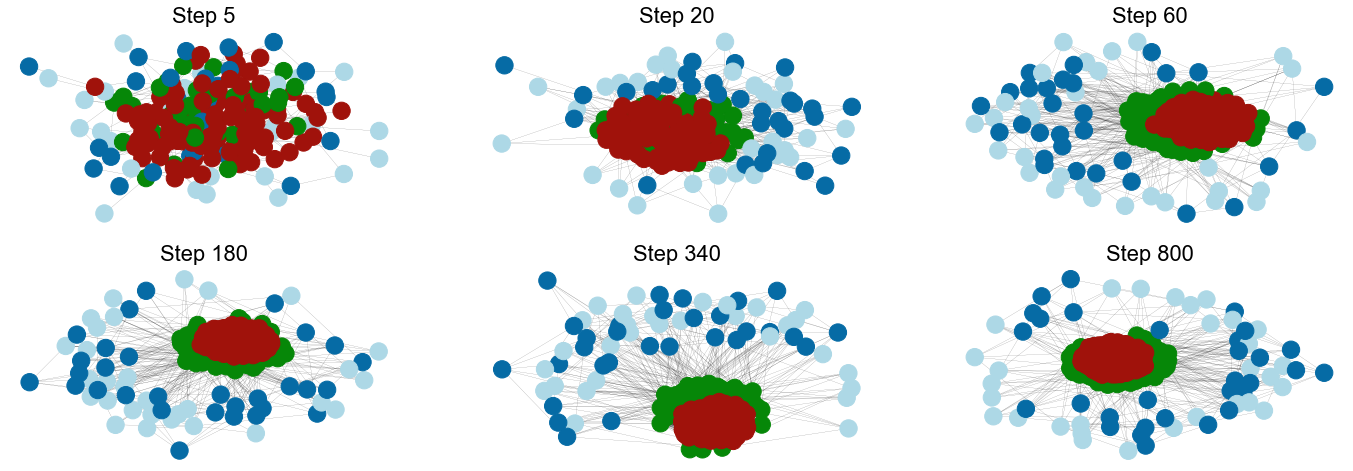

In [32]:
# create the df with all the collected agent-level variables
agent_df = model.datacollector.get_agent_vars_dataframe().xs(0, level='Step')['Type']

''' associate each agent_type to a color '''
dict_ids_type = {agent_df.index[i]:('#A0120B' if agent_df[i]=="MA" else '#068708' if agent_df[i]=="NA" else '#066BA5' if agent_df[i]=="TA" else 'lightblue') for i in range(len(agent_df))}

''' creating lists with all the connections (at given step): [ [(nodei,nodej),(nodei,nodeh)...], [(nodej,nodeh)...] ]'''
edge_list_1 = get_edge_list(model, step_num = 5)
edge_list_2 = get_edge_list(model, step_num = 20)
edge_list_3 = get_edge_list(model, step_num = 60)
edge_list_4 = get_edge_list(model, step_num = 180)
edge_list_5 = get_edge_list(model, step_num = 340)
edge_list_6 = get_edge_list(model, step_num = N_steps-1)

''' creating graphs '''
G1 = create_graph(edge_list_1, dict_ids_type)
G2 = create_graph(edge_list_2, dict_ids_type)
G3 = create_graph(edge_list_3, dict_ids_type)
G4 = create_graph(edge_list_4, dict_ids_type)
G5 = create_graph(edge_list_5, dict_ids_type)
G6 = create_graph(edge_list_6, dict_ids_type)
    
''' plotting graphs '''
matplotlib.rcParams['figure.figsize']= [24, 8]

# create the pos relative to each Graph
pos1 = nx.spring_layout(G1)  # fruchterman_reingold_layout, kamada_kawai_layout, spring_layout
pos2 = nx.spring_layout(G2) 
pos3 = nx.spring_layout(G3) 
pos4 = nx.spring_layout(G4) 
pos5 = nx.spring_layout(G5) 
pos6 = nx.spring_layout(G6) 

# plot each Graph
plt.subplot(231)
graph_plot(G1, pos1, title="Step 5",  width = 0.1)
plt.subplot(232)
graph_plot(G2, pos2, title="Step 20", width = 0.1)
plt.subplot(233)
graph_plot(G3, pos3, title="Step 60", width = 0.1)
plt.subplot(234)
graph_plot(G4, pos4, title="Step 180", width = 0.1)
plt.subplot(235)
graph_plot(G5, pos5, title="Step 340", width = 0.1)
plt.subplot(236)
graph_plot(G6, pos6, title="Step "+str(N_steps), width = 0.1)

In [33]:
''' Get the average number of MA encountered by each agent_type '''
agent_df = model.datacollector.get_agent_vars_dataframe()
agent_df['Num_Agents'] = 1
num_agents = agent_df.xs(N_steps-1, level="Step").groupby("Type").sum()["Num_Agents"].tolist()
agent_df.xs(N_steps-1, level="Step").groupby("Type").sum()/[1,num_agents,num_agents,1]

# we average also Num_Trust_values, which allows to get an idea of how many other agents each
# agent type visited

,Wealth,MA_encoutered,Num_Trust_values,Num_Agents
Type,,,,
MA,14558712.0,78.82,114.680000,100.0
NA,997989.0,56.90,67.700000,40.0
TA,560667.0,54.50,40.166667,30.0
TAplus,392407.0,14.10,18.700000,30.0


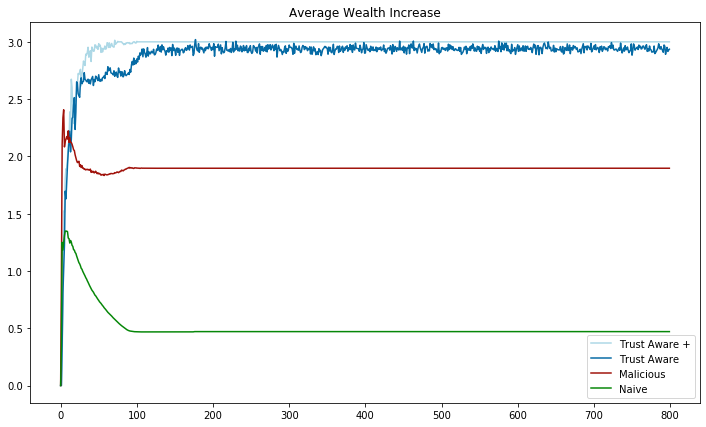

In [35]:
model_df = model.datacollector.get_model_vars_dataframe()[["Avg_TAp_wealth","avg_TA_wealth", "avg_MA_wealth", "avg_NA_wealth"]]
model_df.columns=["Trust Aware +", "Trust Aware", "Malicious", "Naive"]
matplotlib.rcParams['figure.figsize']= [12,7]
model_df.plot(color = ['lightblue', '#066BA5','#A0120B','#068708'], title = "Average Wealth Increase")

    Since TAplus, compared to our TA, only take into account the opinion of agents trustable in the 'advice' dimension, they are able to reach an equilibrium passing through less MA agents. 
    It is crucial that they encounter at least one MA agent, as they need to fill a blacklist with at least one such agent in order to assess trustworthiness of neighbours in WI. Until this happens, they will fill their neighbourhoods only by sendin friend requestes at random. Another crucial factor is that, once they find a MA agent to put in the blacklist, they will also need to to find a TA or TAplus to connect to, so that they can take advantage of his own experience to obtain reputation scores.
    Thus, even though the neighbourhood is filled mostly thanks to friend requestes sent at random, the decision rule that allows them to avoid accepting MA requests will favour them, making them encounter significantly less MAs and gaining more average returns than other agents, even in the long run, as TAs will still be vulnerable to MA incoming friend requests 
    

<a id="n_experiment_4"> </a>
# Experiment 4

**TAplus will now have the possibility of observing DI, and will send connection requests only to agents who seem trustworthy based on their prior due to observation and on the opinion of trustworthy neighbours**




- [Back on top](#top)
- [Back to functions to plot results](#results_functions)

In [36]:
''' MODEL PARAMETERS '''
N = 200       # num agents
N_steps = 400 # num steps

# agent type distribution
TAplus_perc = 0.15     # % of Trust-Aware-plus we want
TA_perc     = 0.15  # % of Trust-Aware we want
MA_perc     = 0.5 # % of Malicious we want
NA_perc     = 1 - MA_perc - TA_perc - TAplus_perc    # % of Naive we want

''' AGENT PARAMETERS '''
alpha_vals = [0.2, 0.2]       # values of alpha for DI and WI (must be > 0)
beta_vals  = [-0.3, -0.3]     # values of beta for DI and WI  (must be < 0)
DT = 0.25                     # threshold relevant for WI decision rule, set to 0.25 in the paper
obs_prob = 0.001              # probability of observing a single interaction, computed at each time-step for every interaction

heter_omegas = True
omegas_mean  = 0.3
omegas_var   = 0.5

# specify characteristics of TA and TAplus. 
# Here we let TAplus be and "Observer" and a "Th+"
TAplus_TA_chars = [['TAplus', 5, "TTFT", "Ho", "Mo", "Th+", obs_prob], ['TA', 5, "TTFT", "Ho", "Mo", "Th", 0]]
    
# doesn't do anything if heter_omegas = True
omega_vals = [0.6, -0.6]      # values of omega (upper threshold; between -1 and 1) and OMEGA (between -1 and 1; if DI trust > omega, agent is considered trustworthy)

''' RUN THE MODEL '''
model = GameModel_extended(N,                                     # <--- intitialize the model
                  TAplus_perc, TA_perc, MA_perc, NA_perc,
                  alpha_vals[0], alpha_vals[1],
                  beta_vals[0], beta_vals[1],
                  omega_vals[0], omega_vals[1],    # doesn't do anything if heter_omegas = True
                  DT,
                  heter_omegas, omegas_mean, omegas_var    
                 ) 

for i in range(N_steps):                                 # <--- Run the model for N_steps steps
    model.step()

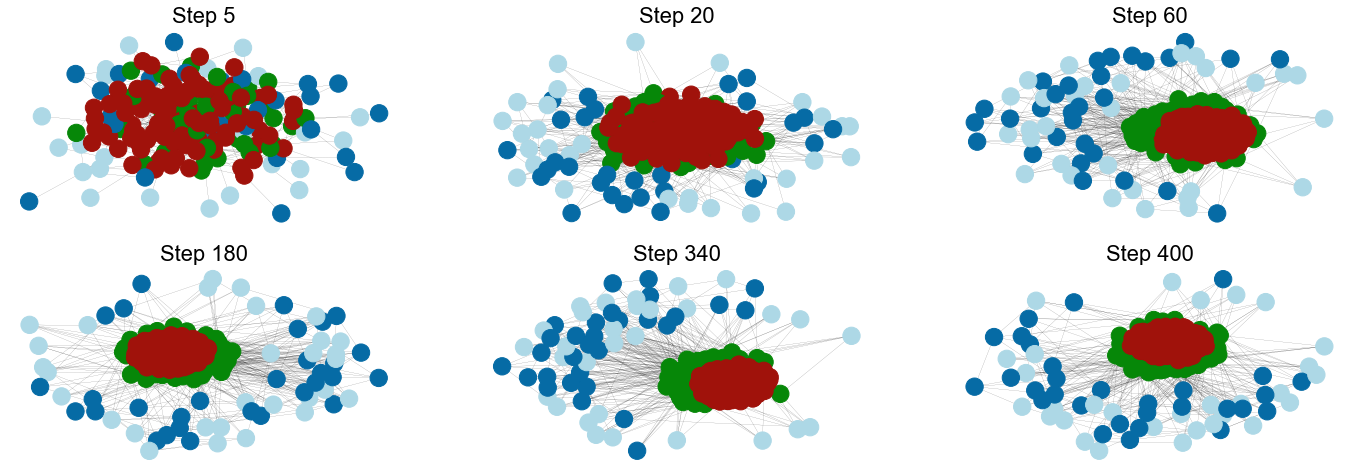

In [37]:
# create the df with all the collected agent-level variables
agent_df = model.datacollector.get_agent_vars_dataframe().xs(0, level='Step')['Type']

''' associate each agent_type to a color '''
dict_ids_type = {agent_df.index[i]:('#A0120B' if agent_df[i]=="MA" else '#068708' if agent_df[i]=="NA" else '#066BA5' if agent_df[i]=="TA" else 'lightblue') for i in range(len(agent_df))}

''' creating lists with all the connections (at given step): [ [(nodei,nodej),(nodei,nodeh)...], [(nodej,nodeh)...] ]'''
edge_list_1 = get_edge_list(model, step_num = 5)
edge_list_2 = get_edge_list(model, step_num = 20)
edge_list_3 = get_edge_list(model, step_num = 60)
edge_list_4 = get_edge_list(model, step_num = 180)
edge_list_5 = get_edge_list(model, step_num = 340)
edge_list_6 = get_edge_list(model, step_num = N_steps-1)

''' creating graphs '''
G1 = create_graph(edge_list_1, dict_ids_type)
G2 = create_graph(edge_list_2, dict_ids_type)
G3 = create_graph(edge_list_3, dict_ids_type)
G4 = create_graph(edge_list_4, dict_ids_type)
G5 = create_graph(edge_list_5, dict_ids_type)
G6 = create_graph(edge_list_6, dict_ids_type)
    
''' plotting graphs '''
matplotlib.rcParams['figure.figsize']= [24, 8]

# create the pos relative to each Graph
pos1 = nx.spring_layout(G1)  # fruchterman_reingold_layout, kamada_kawai_layout, spring_layout
pos2 = nx.spring_layout(G2) 
pos3 = nx.spring_layout(G3) 
pos4 = nx.spring_layout(G4) 
pos5 = nx.spring_layout(G5) 
pos6 = nx.spring_layout(G6) 

# plot each Graph
plt.subplot(231)
graph_plot(G1, pos1, title="Step 5",  width = 0.1)
plt.subplot(232)
graph_plot(G2, pos2, title="Step 20", width = 0.1)
plt.subplot(233)
graph_plot(G3, pos3, title="Step 60", width = 0.1)
plt.subplot(234)
graph_plot(G4, pos4, title="Step 180", width = 0.1)
plt.subplot(235)
graph_plot(G5, pos5, title="Step 340", width = 0.1)
plt.subplot(236)
graph_plot(G6, pos6, title="Step "+str(N_steps), width = 0.1)

In [38]:
''' Get the average number of MA encountered by each agent_type '''
agent_df = model.datacollector.get_agent_vars_dataframe()
agent_df['Num_Agents'] = 1
#agent_df = agent_df.assign(Num_Agents=1)
num_agents = agent_df.xs(N_steps-1, level="Step").groupby("Type").sum()["Num_Agents"].tolist()
agent_df.xs(N_steps-1, level="Step").groupby("Type").sum()/[1,num_agents,1,1]

,Wealth,MA_encoutered,Num_Trust_values,Num_Agents
Type,,,,
MA,6911752.0,78.080000,11515.0,100.0
NA,447054.0,58.075000,2710.0,40.0
TA,261676.0,57.766667,1223.0,30.0
TAplus,221489.0,19.466667,646.0,30.0


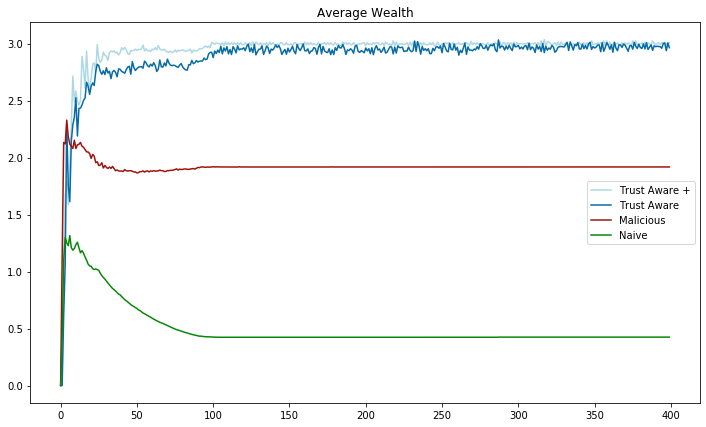

In [39]:
model_df = model.datacollector.get_model_vars_dataframe()[["Avg_TAp_wealth","avg_TA_wealth", "avg_MA_wealth", "avg_NA_wealth"]]
model_df.columns=["Trust Aware +", "Trust Aware", "Malicious", "Naive"]
matplotlib.rcParams['figure.figsize']= [12,7]
model_df.plot(color = ['lightblue', '#066BA5','#A0120B','#068708'], title = "Average Wealth")

    Having TA+ use the Th+ policy means that,to actually add someone in the beginning, they need to have observed that someone for enough interactions to have a good prior (or they must be Super-Trusters)
    

<a id ="batch"> </a>
# Batch Run for calibration and sensitivity

Generally the outputs of interest are: 
- average number of MA in TA or TA+ neighbourhoods
>
> It allows us to check if these agents reach an equilibrium (i.e. they don't keep exploring MA agents towards the final steps)
>
- average number of MA encountered by TA or TA+
>
> It allows us to see if the evaluated policy actually helps to avoid these agents to have to interact with every MA
>


Notes: 
- it can take a lot of time. To speed up things, one can silence the lines about observers in the agent class, in the direct interactions function (except if it's experiment 4). Also one can go to the model class and silence unnecessary model data reporters
- using the batchrunner while changing alpha and betas can be suboptimal since it goes through all combinations, requiring even more time. We ideated a way to get the avg number of MA in TA neighbourhood overcoming this problem, however this made difficult to retrieve information about the average number of MA encountered by type. Thus, only for experiment 3, which is the most important, we also run a batchrunner, but we manually changed the agent class function so that both alphas are equal to d_alpha and both betas are equal to d_beta. Indeed, we anyway use the same values for direct and indirect interactions, but by doing so we can change only one variable in the batchrunner and save a lot of time 
- we generally run 3-5 iterations for each value of the paramter that we change (e.g. for 5 iterations of experiment 3 sensitivity 25+ minutes are required)

## Experiment 1:
We find that TA manage to isolate themselves between steps 150 and 200, despite the particolar values attributed to the parameters.

When checking for changes on omega, we notice that the average number of MA encountered stays extremely consistent

### Experiment 1: no *Super-Trusters*

we use homogenous omegas to ensure that no omega is < 0 and no OMEGA is > 0, no TA will manage to build any connection at all

In [16]:
''' MODEL PARAMETERS '''
N = 200   # num agents
N_steps = 400 # num steps

# agent type distribution
TAplus_perc = 0     # % of Trust-Aware-plus we want
TA_perc     = 0.66  # % of Trust-Aware we want
MA_perc     = 0.34  # % of Malicious we want
NA_perc     = 1 - MA_perc - TA_perc - TAplus_perc    # % of Naive we want

''' AGENT PARAMETERS '''
alpha_vals = [0.2, 0.2]       # values of alpha for DI and WI (must be > 0)
beta_vals  = [-0.3, -0.3]     # values of beta for DI and WI  (must be < 0)
omega_vals = [0.6, -0.6]      # values of omega (upper threshold; between -1 and 1) and OMEGA (between -1 and 1; if DI trust > omega, agent is considered trustworthy)
DT = 0.25                     # threshold relevant for WI decision rule, set to 0.25 in the paper

''' RUN THE MODEL '''

model = GameModel_extended(N,                                     # <--- intitialize the model
                  TAplus_perc, TA_perc, MA_perc, NA_perc,
                  alpha_vals[0], alpha_vals[1],
                  beta_vals[0], beta_vals[1],
                  omega_vals[0], omega_vals[1],     # OMEGA and omega
                  DT,
                  False, -0,9, 0,9
                 ) 

for i in range(N_steps):                                 # <--- Run the model for N_steps steps
    model.step()

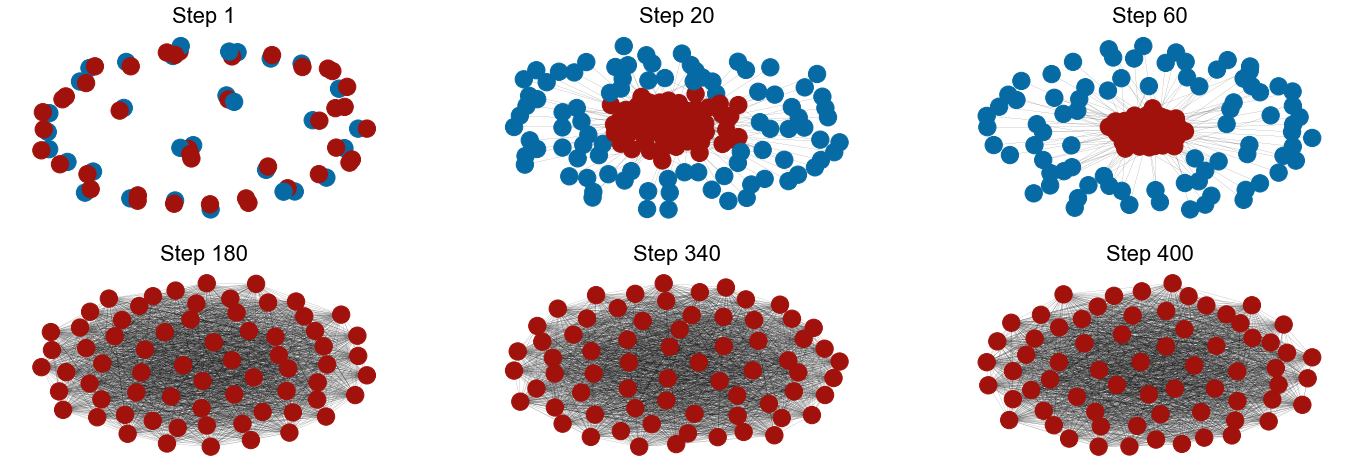

In [17]:
# create the df with all the collected agent-level variables
agent_df = model.datacollector.get_agent_vars_dataframe().xs(0, level='Step')['Type']

''' associate each agent_type to a color '''
dict_ids_type = {agent_df.index[i]:('#A0120B' if agent_df[i]=="MA" else '#068708' if agent_df[i]=="NA" else '#066BA5') for i in range(len(agent_df))}

''' creating lists with all the connections (at given step): [ [(nodei,nodej),(nodei,nodeh)...], [(nodej,nodeh)...] ]'''
edge_list_1 = get_edge_list(model, step_num = 1)
edge_list_2 = get_edge_list(model, step_num = 20)
edge_list_3 = get_edge_list(model, step_num = 60)
edge_list_4 = get_edge_list(model, step_num = 180)
edge_list_5 = get_edge_list(model, step_num = 340)
edge_list_6 = get_edge_list(model, step_num = N_steps-1)

''' creating graphs '''
G1 = create_graph(edge_list_1, dict_ids_type)
G2 = create_graph(edge_list_2, dict_ids_type)
G3 = create_graph(edge_list_3, dict_ids_type)
G4 = create_graph(edge_list_4, dict_ids_type)
G5 = create_graph(edge_list_5, dict_ids_type)
G6 = create_graph(edge_list_6, dict_ids_type)
    
''' plotting graphs '''
matplotlib.rcParams['figure.figsize']= [24, 8]

# create the pos relative to each Graph
pos1 = nx.spring_layout(G1)  # fruchterman_reingold_layout, kamada_kawai_layout, spring_layout
pos2 = nx.spring_layout(G2) 
pos3 = nx.spring_layout(G3) 
pos4 = nx.spring_layout(G4) 
pos5 = nx.spring_layout(G5) 
pos6 = nx.spring_layout(G6) 

# plot each Graph
plt.subplot(231)
graph_plot(G1, pos1, title="Step 1",  width = 0.1)
plt.subplot(232)
graph_plot(G2, pos2, title="Step 20", width = 0.1)
plt.subplot(233)
graph_plot(G3, pos3, title="Step 60", width = 0.1)
plt.subplot(234)
graph_plot(G4, pos4, title="Step 180", width = 0.1)
plt.subplot(235)
graph_plot(G5, pos5, title="Step 340", width = 0.1)
plt.subplot(236)
graph_plot(G6, pos6, title="Step 400", width = 0.1)

### Experiment 1: sensitivity for omegas

In [95]:
# 1 . define the parameters that we want to keep fixed for each experiment
fixed_params = {
                "N"       : 200,
                "TAplusp" : 0,
                "TAp"     : .66, #Exp 1 populations
                "MAp"     : .34,
                "NAp"     : 0,
                "d_alpha" : .2,  
                "w_alpha" : .2,
                "d_beta"  : -.3,
                "w_beta"  : -.3,   
                "omega"   : .0,
                "OMEGA"  : -.97,
                "DT"      : .25,
                "heter_omegas": True,
                "omegas_var":.4,
                #TAplus_TA_chars
               }


# 2 . define the parameters that we want to test, that is we want to change them in different experiments
variable_params = {"omegas_mean":[.1,.3,.5,.7,.9]} 


n_iters = 5     # CAREFUL HERE

# 3. initialize the BatchRunner
batch_run = BatchRunner(
    GameModel_extended,  
    variable_params, 
    fixed_params, 
    iterations=n_iters,   
    max_steps=401,  # AND HERE
    
    model_reporters={"Data Collector": lambda m: m.datacollector}, 
    
    agent_reporters={
                     "Wealth": 'wealth',
                     "Type":'type',
                     "Neigh evo":'neigh_evo',
                     "MA_encoutered":"malicious_encountered",
                     "Num_Trust_values":"len_DI_dict"
                    }
)

# 4. Run the experiments
batch_run.run_all()  

25it [20:39, 49.57s/it]


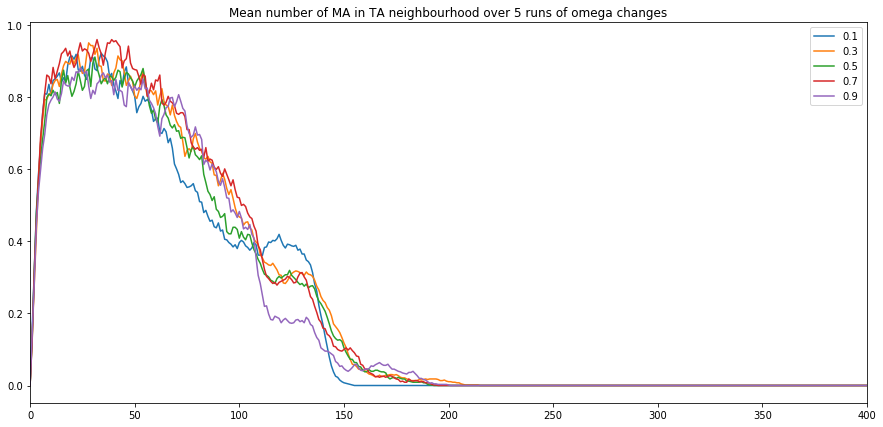

In [96]:
#############################################
# Horrible garble of data manipulation below.
#############################################
''' Plots the avg result over n_iter runs of the average number of MA in TA neighbourhood per step'''
#n_iters =  defined above before batch run 
mdf = batch_run.get_model_vars_dataframe()
OMGs = mdf.omegas_mean.unique()
useful_info = []
for j in range(len(OMGs)):
    same_omega = []
    for i in range(n_iters):
        same_omega.append(mdf["Data Collector"][j*n_iters+i].get_model_vars_dataframe()['MA_in_TA_neigh'])
    
    useful_info.append(same_omega)

def_df = pd.DataFrame(useful_info[0][0])
def_df.columns = ['0']
r = 0
for j in range(len(useful_info)):
    for i in range(len(useful_info[j])):
        def_df['{}'.format(r)] = pd.DataFrame(useful_info[j][i])
        r+=1
        
df_plot_om = pd.DataFrame(def_df.iloc[:,:n_iters].mean(axis=1))
for i in range(len(OMGs)):
    df_plot_om['{}'.format(OMGs[i])] = def_df.iloc[:,(i*n_iters):(i*n_iters+n_iters)].mean(axis=1)
    
df_plot_om.iloc[:,1:].plot(figsize = [15,7], title = 'Mean number of MA in TA neighbourhood over {} runs of omega changes'.format(n_iters)) 

In [97]:
batch_run.get_agent_vars_dataframe()

,omegas_mean,Run,AgentId,MA_encoutered,Neigh evo,Num_Trust_values,Type,Wealth,N,TAplusp,...,NAp,d_alpha,w_alpha,d_beta,w_beta,omega,OMEGA,DT,heter_omegas,omegas_var
0,0.1,0,0,22,"{0: [], 1: [], 2: [], 3: [149, 161], 4: [149, ...",27,TA,5249,200,0,...,0,0.2,0.2,-0.3,-0.3,0.0,-0.97,0.25,True,0.4
127,0.1,0,127,20,"{0: [], 1: [169], 2: [169], 3: [169], 4: [169]...",26,TA,6217,200,0,...,0,0.2,0.2,-0.3,-0.3,0.0,-0.97,0.25,True,0.4
128,0.1,0,128,134,"{0: [], 1: [], 2: [183], 3: [147, 183], 4: [14...",135,TA,52449,200,0,...,0,0.2,0.2,-0.3,-0.3,0.0,-0.97,0.25,True,0.4
129,0.1,0,129,20,"{0: [], 1: [], 2: [], 3: [], 4: [], 5: [165], ...",25,TA,5351,200,0,...,0,0.2,0.2,-0.3,-0.3,0.0,-0.97,0.25,True,0.4
130,0.1,0,130,32,"{0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: ...",38,TA,6009,200,0,...,0,0.2,0.2,-0.3,-0.3,0.0,-0.97,0.25,True,0.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4869,0.9,24,69,34,"{0: [], 1: [], 2: [], 3: [132], 4: [132], 5: [...",42,TA,7473,200,0,...,0,0.2,0.2,-0.3,-0.3,0.0,-0.97,0.25,True,0.4
4870,0.9,24,70,7,"{0: [], 1: [196], 2: [], 3: [], 4: [186], 5: [...",12,TA,5628,200,0,...,0,0.2,0.2,-0.3,-0.3,0.0,-0.97,0.25,True,0.4
4871,0.9,24,71,23,"{0: [], 1: [182], 2: [], 3: [146], 4: [], 5: [...",28,TA,5385,200,0,...,0,0.2,0.2,-0.3,-0.3,0.0,-0.97,0.25,True,0.4
4861,0.9,24,61,28,"{0: [], 1: [], 2: [162], 3: [], 4: [], 5: [], ...",34,TA,5973,200,0,...,0,0.2,0.2,-0.3,-0.3,0.0,-0.97,0.25,True,0.4


In [98]:
''' The average number of MA encountered  '''
agent_df = batch_run.get_agent_vars_dataframe()
agent_df['Num_Agents'] = 1
#agent_df = agent_df.assign(Num_Agents=1)
#num_agents = agent_df.groupby("Type").sum()["Num_Agents"].tolist()
agent_df = agent_df[["Type","Run","MA_encoutered", "omegas_mean"]]
agent_df = agent_df[agent_df["Type"] == "TA"]
agent_df.groupby(["Run","Type"]).sum()/[TAp*N,180]
# omega_mean values should be divided by a different factor, but it isn't really relevant

,,MA_encoutered,omegas_mean
Run,Type,,
0,TA,41.163636,0.12
1,TA,41.818182,0.12
2,TA,40.190909,0.12
3,TA,39.954545,0.12
4,TA,39.236364,0.12
5,TA,42.190909,0.36
6,TA,41.654545,0.36
7,TA,43.972727,0.36
8,TA,40.763636,0.36


values stay very consistent

### Experiment 1: sensitivity for alphas

In [22]:
'''Unchanged paramenters for sensitivity'''
N            = 200       
N_steps      = 400 
TAplus_perc  = 0     
TA_perc      = 0.66 # Exp 1 populations  
MA_perc      = 0.34  
NA_perc      = 0   
beta_vals    = [-0.3, -0.3]   
DT           = 0.25                  
heter_omegas = True
omegas_mean  = .3
omegas_var   = 0.4
omega_vals   = [0.6, -0.6]# doesn't do anything if heter_omegas = True

'''Varied param'''
alpha_vals = [[0.1, 0.1],[.3,.3],[.5,.5],[.7,.7],[.9,.9]] 
n_iters = 3  # how many iter for same alfa val

''' RUN THE MODEL '''
tot_res = [] # store results

for i in range(n_iters):
    m_res = []
    for a in alpha_vals:
        model = GameModel_extended(N, TAplus_perc, TA_perc, MA_perc, NA_perc, 
                                   a[0], a[1], #Changes 
                          beta_vals[0], beta_vals[1], omega_vals[0], omega_vals[1],DT, heter_omegas, omegas_mean, omegas_var) 

        for i in range(N_steps):                                 
            model.step()

        m_res.append(model.datacollector.get_model_vars_dataframe())
    tot_res.append(m_res)

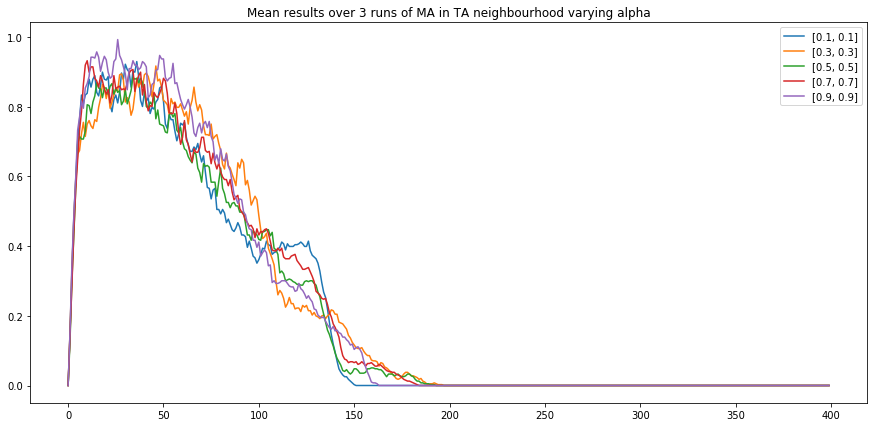

In [43]:
# Parse thorugh list end obtain interesting data then computes the mean and plots
#n_iters is defined above
n_ = len(alpha_vals)
dfsf = []
for i in range(len(tot_res)):
    for j in range(len(tot_res[0])):
        dfsf.append(pd.DataFrame(tot_res[i][j])['MA_in_TA_neigh'])
        
    
a1 = pd.DataFrame(dfsf).iloc[::n_] # selects 1 every 5 row which should have the same alphas values
a2 = pd.DataFrame(dfsf).iloc[1::n_]
a3 = pd.DataFrame(dfsf).iloc[2::n_]
a4 = pd.DataFrame(dfsf).iloc[3::n_]
a5 = pd.DataFrame(dfsf).iloc[4::n_]
pd.DataFrame([a1.mean(),a2.mean(),a3.mean(),a4.mean(),a5.mean()], index = [str(a) for a in alpha_vals]).T.plot(figsize = [15, 7],title = 'Mean num MA in TA neighbourhood over {} runs, varying alpha'.format(n_iters))

No notable differences, individual differences are probably due to stochasticity more than anything else

### Experiment 1: sensitivity for beta

In [44]:
'''Unchanged paramenters for sensitivity'''
N            = 200       
N_steps      = 400 
TAplus_perc  = 0     
TA_perc      = 0.66  # Exp 1 populations
MA_perc      = 0.34  
NA_perc      = 0    
alpha_vals   = [0.2, 0.2]   
DT           = 0.25                  
heter_omegas = True
omegas_mean  = .3
omegas_var   = 0.4
omega_vals   = [0.6, -0.6]# doesn't do anything if heter_omegas = True

'''Varied param'''
beta_vals  = [[-0.1, -0.1],[-.3,-.3],[-.5,-.5],[-.7,-.7],[-.9,-.9]]
n_iters = 3  # how many iter for same beta val

''' RUN THE MODEL '''
tot_res = [] # store results

for i in range(n_iters):
    m_res = []
    for b in beta_vals:
        model = GameModel_extended(N, TAplus_perc, TA_perc, MA_perc, NA_perc, alpha_vals[0], alpha_vals[1], 
                                   b[0], b[1],    #Changes
                                   omega_vals[0], omega_vals[1],DT, heter_omegas, omegas_mean, omegas_var) 

        for i in range(N_steps):                                 
            model.step()

        m_res.append(model.datacollector.get_model_vars_dataframe())
    tot_res.append(m_res)

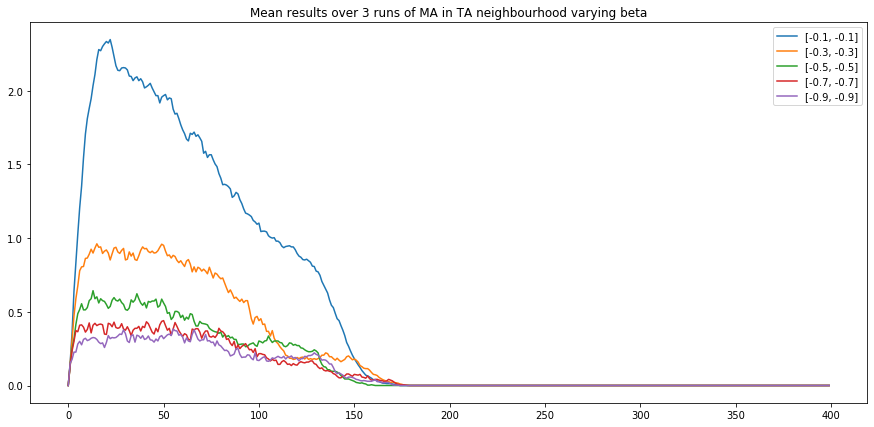

In [45]:
# Parse thorugh list end obtain interesting data then computes the mean and plots
#n_iters is defined above
n_ = len(beta_vals) # needed to identify same betas results in an ugly df
dfsf = []
for i in range(len(tot_res)):
    for j in range(len(tot_res[0])):
        dfsf.append(pd.DataFrame(tot_res[i][j])['MA_in_TA_neigh'])
    
a1 = pd.DataFrame(dfsf).iloc[::n_] # selects 1 every 5 row which should have the same alphas values
a2 = pd.DataFrame(dfsf).iloc[1::n_]
a3 = pd.DataFrame(dfsf).iloc[2::n_]
a4 = pd.DataFrame(dfsf).iloc[3::n_]
a5 = pd.DataFrame(dfsf).iloc[4::n_]
pd.DataFrame([a1.mean(),a2.mean(),a3.mean(),a4.mean(),a5.mean()], index = [str(a) for a in beta_vals]).T.plot(figsize = [15, 7],title = 'Mean num MA in TA neighbourhood over {} runs, varying beta'.format(n_iters))

The most significant gap is between beta = -0.1 and beta = -0.3. Having a lesser beta means that it takes more time to get rid of MA agents. The more time they are in a neighourhood, the more chances they can also reccomend their peers to other TA. Despite this, though, TA seem able to get rid of them by around the same step, neverthless the value of beta

## Experiment 2
We find that, nevertheless of the values of beta,alpha and omegas, the result that NA can fool TA into accepting MA is reamins, as shown by the fact that most lines are wiggly even around step 400, despite the slab imposed by them being averages of values averaged over runs.


When checking for changes on omega, we notice that the average number of MA encountered can vary a bit in the same run, but is generally consistent, in the sense that it never happens that TA have to explore all MA

### Experiment 2: sensitivity on omega 

In [41]:
N = 200
TAp = 0.55

fixed_params = {
                "N"       : N,
                "TAplusp" : 0,
                "TAp"     : TAp, # Exp 2 populations
                "MAp"     : .34,
                "NAp"     : .11,
                "d_alpha" : .2,  
                "w_alpha" : .2,
                "d_beta"  : -.3,
                "w_beta"  : -.3,   
                "omega"   : .0,
                "OMEGA"  : -.97,
                "DT"      : .25,
                "heter_omegas": True,
                "omegas_var":.4,
                #TAplus_TA_chars
               }

variable_params = {"omegas_mean":[.1,.3,.5,.7,.9]} 


n_iters = 3      

batch_run = BatchRunner(
    GameModel_extended,  
    variable_params, 
    fixed_params, 
    iterations=n_iters,   
    max_steps=401, 
    
    model_reporters={"Data Collector": lambda m: m.datacollector,
                     "Avg_Neigh": avg_num_neighbours,
                     "avg_TA_wealth": avg_TA_wealth,
                     "avg_MA_wealth": avg_MA_wealth,
                     "avg_NA_wealth":avg_NA_wealth,
                     "Avg_TAp_wealth":avg_TAp_wealth,
                     "Avg_TA_neigh":avg_num_neighbours_TA,
                     "ACC_requests_TA":TA_acc_requests,
                     "Avg_TAp_neigh":avg_num_neighbours_TAplus,
                     "avg_MA_in_TA_neigh":avg_MA_in_TA_neigh
                    }, 
    
    agent_reporters={"Wealth": 'wealth',
                     "Type":'type',
                     "Neigh evo":'neigh_evo',
                     "MA_encoutered":"malicious_encountered",
                     "Num_Trust_values":"len_DI_dict"
                    }
)

batch_run.run_all()  

15it [03:17, 13.19s/it]


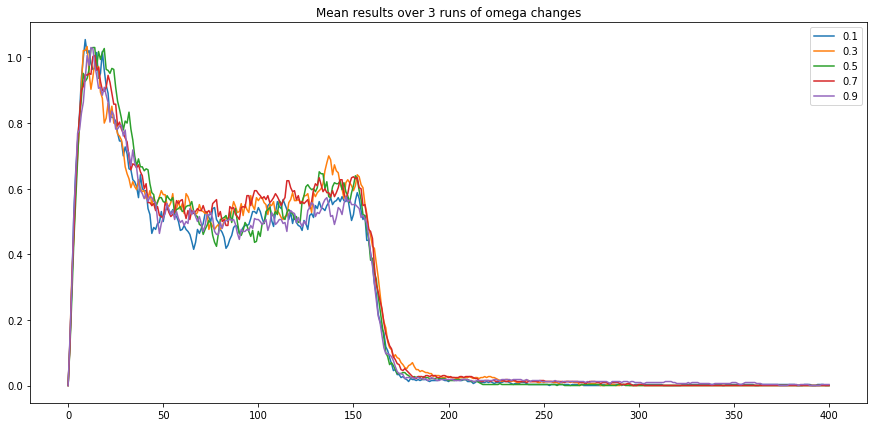

In [47]:
#############################################
# Horrible garble of data manipulation below.
#############################################
''' Plots the avg result over n_iter runs of the average number of MA in TA neighbourhood per step'''
#n_iters = 20 defined above before batch run 

mdf = batch_run.get_model_vars_dataframe()
OMGs = mdf.omegas_mean.unique()
useful_info = []
for j in range(len(OMGs)):
    same_omega = []
    for i in range(n_iters):
        same_omega.append(mdf["Data Collector"][j*n_iters+i].get_model_vars_dataframe()['MA_in_TA_neigh'])
    
    useful_info.append(same_omega)

def_df = pd.DataFrame(useful_info[0][0])
def_df.columns = ['0']
r = 0
for j in range(len(useful_info)):
    for i in range(len(useful_info[j])):
        def_df['{}'.format(r)] = pd.DataFrame(useful_info[j][i])
        r+=1
        
df_plot_om = pd.DataFrame(def_df.iloc[:,:n_iters].mean(axis=1))
for i in range(len(OMGs)):
    df_plot_om['{}'.format(OMGs[i])] = def_df.iloc[:,(i*n_iters):(i*n_iters+n_iters)].mean(axis=1)
    
df_plot_om.iloc[:,1:].plot(figsize = [15,7], title = 'Mean num MA in TA neighbourhood over {} runs, changing omegas mean'.format(n_iters))    

In [51]:
batch_run.get_agent_vars_dataframe()

,omegas_mean,Run,AgentId,MA_encoutered,Neigh evo,Num_Trust_values,Type,Wealth,N,TAplusp,...,NAp,d_alpha,w_alpha,d_beta,w_beta,omega,OMEGA,DT,heter_omegas,omegas_var
0,0.1,0,0,9,"{0: [], 1: [171], 2: [171], 3: [154], 4: [67],...",14,TA,5777,200,0,...,0.11,0.2,0.2,-0.3,-0.3,0.0,-0.97,0.25,True,0.4
127,0.1,0,127,67,"{0: [], 1: [186], 2: [186, 42, 185], 3: [186, ...",126,MA,57580,200,0,...,0.11,0.2,0.2,-0.3,-0.3,0.0,-0.97,0.25,True,0.4
128,0.1,0,128,67,"{0: [], 1: [], 2: [112], 3: [112, 198], 4: [11...",126,MA,57054,200,0,...,0.11,0.2,0.2,-0.3,-0.3,0.0,-0.97,0.25,True,0.4
129,0.1,0,129,67,"{0: [], 1: [113], 2: [173, 113], 3: [173, 69, ...",131,MA,58958,200,0,...,0.11,0.2,0.2,-0.3,-0.3,0.0,-0.97,0.25,True,0.4
130,0.1,0,130,67,"{0: [], 1: [186], 2: [186, 169], 3: [186, 169,...",133,MA,61065,200,0,...,0.11,0.2,0.2,-0.3,-0.3,0.0,-0.97,0.25,True,0.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2869,0.9,14,69,8,"{0: [], 1: [135], 2: [], 3: [], 4: [175, 124],...",12,TA,5847,200,0,...,0.11,0.2,0.2,-0.3,-0.3,0.0,-0.97,0.25,True,0.4
2870,0.9,14,70,111,"{0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: ...",89,TA,5383,200,0,...,0.11,0.2,0.2,-0.3,-0.3,0.0,-0.97,0.25,True,0.4
2871,0.9,14,71,125,"{0: [], 1: [], 2: [], 3: [165], 4: [], 5: [], ...",82,TA,7939,200,0,...,0.11,0.2,0.2,-0.3,-0.3,0.0,-0.97,0.25,True,0.4
2861,0.9,14,61,12,"{0: [], 1: [], 2: [], 3: [149], 4: [149], 5: [...",21,TA,7957,200,0,...,0.11,0.2,0.2,-0.3,-0.3,0.0,-0.97,0.25,True,0.4


In [78]:
''' The average number of MA encountered  '''
agent_df = batch_run.get_agent_vars_dataframe()
agent_df['Num_Agents'] = 1
#agent_df = agent_df.assign(Num_Agents=1)
#num_agents = agent_df.groupby("Type").sum()["Num_Agents"].tolist()
agent_df = agent_df[["Type","Run","MA_encoutered", "omegas_mean"]]
agent_df = agent_df[agent_df["Type"] == "TA"]
agent_df.groupby(["Run","Type"]).sum()/[TAp*N,110]

,,MA_encoutered,omegas_mean
Run,Type,,
0,TA,42.881818,0.1
1,TA,41.754545,0.1
2,TA,46.472727,0.1
3,TA,55.481818,0.3
4,TA,41.845455,0.3
5,TA,39.118182,0.3
6,TA,38.881818,0.5
7,TA,49.645455,0.5
8,TA,46.427273,0.5


By adding complexity into the society, adding naive agents, we find that there is more stochasticity. Though there doesn't seem to be any correlation between omega values and the average number of MA encountered by TA agents

### Experiment 2: sensitivity on alpha

In [48]:
'''Unchanged paramenters for sensitivity'''
N            = 200       
N_steps      = 400 
TAplus_perc  = 0     
TA_perc      = 0.55  #Exp 2 populations
MA_perc      = 0.34  
NA_perc      = 0.11    
beta_vals    = [-0.3, -0.3]   
DT           = 0.25                  
heter_omegas = True
omegas_mean  = .3
omegas_var   = 0.4
omega_vals   = [0.6, -0.6] # doesn't do anything if heter_omegas = True

'''Varied param'''
alpha_vals = [[0.1, 0.1],[.3,.3],[.5,.5],[.7,.7],[.9,.9]]     # values of alpha for DI and WI (must be > 0)
n_iters = 3  # how many iter for same alfa val

''' RUN THE MODEL '''
tot_res = [] # store results

for i in range(n_iters):
    m_res = []
    for a in alpha_vals:
        model = GameModel_extended(N, TAplus_perc, TA_perc, MA_perc, NA_perc, 
                                   a[0], a[1], #Changes 
                          beta_vals[0], beta_vals[1], omega_vals[0], omega_vals[1],DT, heter_omegas, omegas_mean, omegas_var) 

        for i in range(N_steps):                                 
            model.step()

        m_res.append(model.datacollector.get_model_vars_dataframe())
    tot_res.append(m_res)

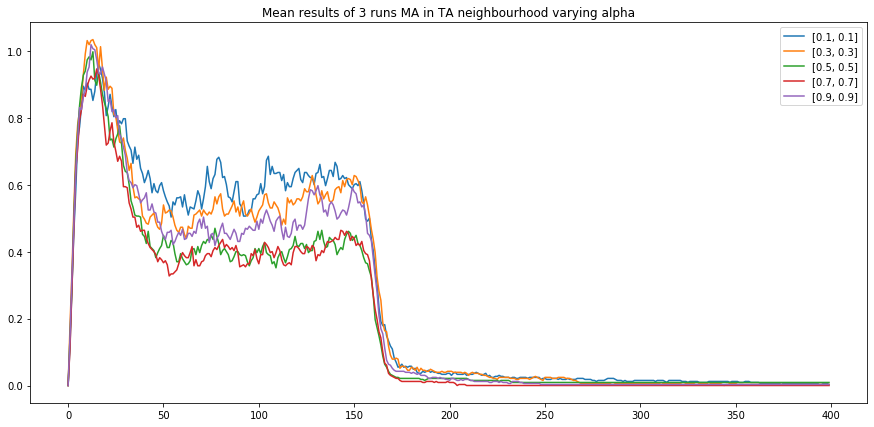

In [49]:
# Parse thorugh list end obtain interesting data then computes the mean and plots
#n_iters is defined above
n_ = len(alpha_vals)
dfsf = []
for i in range(len(tot_res)):
    for j in range(len(tot_res[0])):
        dfsf.append(pd.DataFrame(tot_res[i][j])['MA_in_TA_neigh'])
    
a1 = pd.DataFrame(dfsf).iloc[::n_] # selects 1 every 5 row which should have the same alphas values
a2 = pd.DataFrame(dfsf).iloc[1::n_]
a3 = pd.DataFrame(dfsf).iloc[2::n_]
a4 = pd.DataFrame(dfsf).iloc[3::n_]
a5 = pd.DataFrame(dfsf).iloc[4::n_]
pd.DataFrame([a1.mean(),a2.mean(),a3.mean(),a4.mean(),a5.mean()], index = [str(a) for a in alpha_vals]).T.plot(figsize = [15, 7],title = 'Mean num MA in TA neighbourhood over {} runs, varying alpha'.format(n_iters))

### Experiment 2: sensitivity on beta

In [5]:
'''Unchanged paramenters for sensitivity'''
N            = 200       
N_steps      = 400 
TAplus_perc  = 0     
TA_perc      = 0.55  # Exp 2 populations
MA_perc      = 0.34  
NA_perc      = 0.11
alpha_vals    = [0.2, 0.2]   
DT           = 0.25                  
heter_omegas = True
omegas_mean  = .3
omegas_var   = 0.4
omega_vals   = [0.6, -0.6]# doesn't do anything if heter_omegas = Truedered trustworthy)

'''Varied param'''
beta_vals  = [[-0.1, -0.1],[-.3,-.3],[-.5,-.5],[-.7,-.7],[-.9,-.9]]      # values of alpha for DI and WI (must be > 0)
n_iters = 3  # how many iter for same beta val

''' RUN THE MODEL '''
tot_res = [] # store results

for i in range(n_iters):
    m_res = []
    for b in beta_vals:
        model = GameModel_extended(N, TAplus_perc, TA_perc, MA_perc, NA_perc, alpha_vals[0], alpha_vals[1], 
                                   b[0], b[1],    #Changes
                                   omega_vals[0], omega_vals[1],DT, heter_omegas, omegas_mean, omegas_var) 

        for i in range(N_steps):                                 
            model.step()

        m_res.append(model.datacollector.get_model_vars_dataframe())
    tot_res.append(m_res)

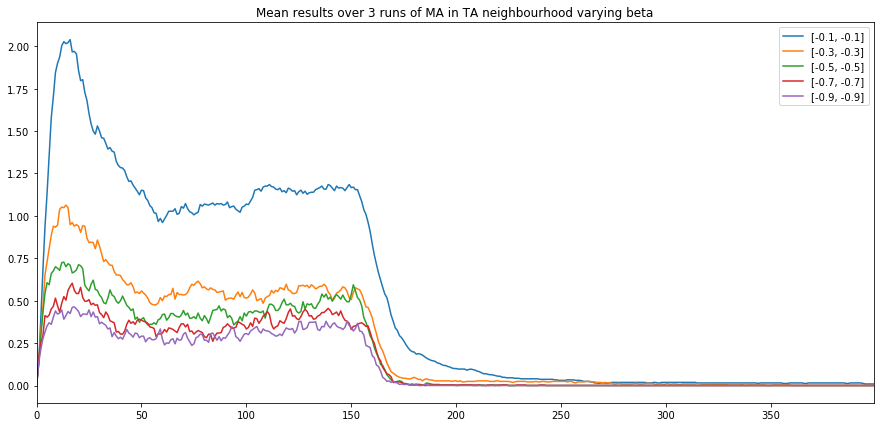

In [6]:
# Parse thorugh list end obtain interesting data then computes the mean and plots
'''For beta'''
#n_iters is defined above
n_ = len(beta_vals)
dfsf = []
for i in range(len(tot_res)):
    for j in range(len(tot_res[0])):
        dfsf.append(pd.DataFrame(tot_res[i][j])['MA_in_TA_neigh'])
    
a1 = pd.DataFrame(dfsf).iloc[::n_] # selects 1 every 5 row which should have the same alphas values
a2 = pd.DataFrame(dfsf).iloc[1::n_]
a3 = pd.DataFrame(dfsf).iloc[2::n_]
a4 = pd.DataFrame(dfsf).iloc[3::n_]
a5 = pd.DataFrame(dfsf).iloc[4::n_]
pd.DataFrame([a1.mean(),a2.mean(),a3.mean(),a4.mean(),a5.mean()], index = [str(a) for a in beta_vals]).T.plot(figsize = [15, 7], title = 'Mean results over {} runs of MA in TA neighbourhood varying beta'.format(n_iters))

## Experiment 3 sensitivity

We find that TAp generally manage to find an equilibrium, except for beta = -0.1, which seems, once again, the single value which has most relevance in our model. This is in line with the literature [3], as low value of beta can hinder the capability of agents to update trust values making them surpass the *Untrustworthy* threshold


We notice that the average number of MA encountered stays extremely consistent around 10-18, proving that this policy can help to significantly reduce the number of MA encounters, despite the values assigned to omegas/alphas/betas

### Experiment 3: sensitivity on omega

In [99]:
N = 200
TAplusp = 0.15

fixed_params = {
                "N"       : N,
                "TAplusp" : TAplusp,
                "TAp"     : 0.15, # Exp 3 populations
                "MAp"     : .50,
                "NAp"     : .20,
                "d_alpha" : .2,  
                "w_alpha" : .2,
                "d_beta"  : -.3,
                "w_beta"  : -.3,   
                "omega"   : .0,
                "OMEGA"  : -.97,
                "DT"      : .25,
                "heter_omegas": True,
                "omegas_var":.4,
                #TAplus_TA_chars
               }

variable_params = {"omegas_mean":[.1,.3,.5,.7,.9]} 


n_iters = 3      

batch_run = BatchRunner(
    GameModel_extended,  
    variable_params, 
    fixed_params, 
    iterations=n_iters,   
    max_steps=401, 
    
    model_reporters={"Data Collector": lambda m: m.datacollector,
                     "Avg_Neigh": avg_num_neighbours,
                     "avg_TA_wealth": avg_TA_wealth,
                     "avg_MA_wealth": avg_MA_wealth,
                     "avg_NA_wealth":avg_NA_wealth,
                     "Avg_TAp_wealth":avg_TAp_wealth,
                     "Avg_TA_neigh":avg_num_neighbours_TA,
                     "ACC_requests_TA":TA_acc_requests,
                     "Avg_TAp_neigh":avg_num_neighbours_TAplus,
                     "avg_MA_in_TA_neigh":avg_MA_in_TA_neigh
                    }, 
    
    agent_reporters={"Wealth": 'wealth',
                     "Type":'type',
                     "Neigh evo":'neigh_evo',
                     "MA_encoutered":"malicious_encountered",
                     "Num_Trust_values":"len_DI_dict"
                    }
)

batch_run.run_all()  

15it [27:31, 110.08s/it]


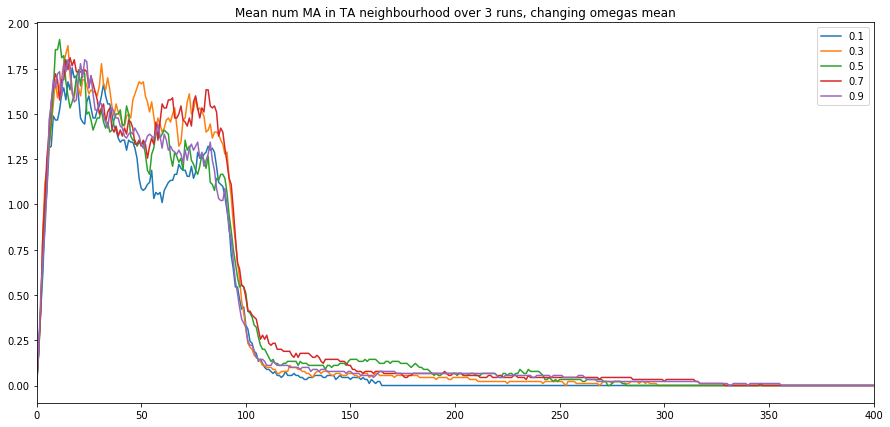

In [100]:
#############################################
# Horrible garble of data manipulation below.
#############################################
''' Plots the avg result over n_iter runs of the average number of MA in TA neighbourhood per step'''
#n_iters = 20 defined above before batch run 

mdf = batch_run.get_model_vars_dataframe()
OMGs = mdf.omegas_mean.unique()
useful_info = []
for j in range(len(OMGs)):
    same_omega = []
    for i in range(n_iters):
        same_omega.append(mdf["Data Collector"][j*n_iters+i].get_model_vars_dataframe()['MA_in_TA_neigh'])
    
    useful_info.append(same_omega)

def_df = pd.DataFrame(useful_info[0][0])
def_df.columns = ['0']
r = 0
for j in range(len(useful_info)):
    for i in range(len(useful_info[j])):
        def_df['{}'.format(r)] = pd.DataFrame(useful_info[j][i])
        r+=1
        
df_plot_om = pd.DataFrame(def_df.iloc[:,:n_iters].mean(axis=1))
for i in range(len(OMGs)):
    df_plot_om['{}'.format(OMGs[i])] = def_df.iloc[:,(i*n_iters):(i*n_iters+n_iters)].mean(axis=1)
    
df_plot_om.iloc[:,1:].plot(figsize = [15,7], title = 'Mean num MA in TA neighbourhood over {} runs, changing omegas mean'.format(n_iters))    

In [101]:
batch_run.get_agent_vars_dataframe()

,omegas_mean,Run,AgentId,MA_encoutered,Neigh evo,Num_Trust_values,Type,Wealth,N,TAplusp,...,NAp,d_alpha,w_alpha,d_beta,w_beta,omega,OMEGA,DT,heter_omegas,omegas_var
0,0.1,0,0,11,"{0: [], 1: [], 2: [117, 197], 3: [117, 197], 4...",17,TAplus,6941,200,0.15,...,0.2,0.2,0.2,-0.3,-0.3,0.0,-0.97,0.25,True,0.4
127,0.1,0,127,78,"{0: [], 1: [128], 2: [128], 3: [128, 99], 4: [...",115,MA,70214,200,0.15,...,0.2,0.2,0.2,-0.3,-0.3,0.0,-0.97,0.25,True,0.4
128,0.1,0,128,78,"{0: [], 1: [127], 2: [148, 127], 3: [127, 124,...",118,MA,69607,200,0.15,...,0.2,0.2,0.2,-0.3,-0.3,0.0,-0.97,0.25,True,0.4
129,0.1,0,129,80,"{0: [], 1: [142], 2: [99, 142], 3: [99, 142], ...",121,MA,69528,200,0.15,...,0.2,0.2,0.2,-0.3,-0.3,0.0,-0.97,0.25,True,0.4
130,0.1,0,130,76,"{0: [], 1: [109], 2: [109, 142, 182], 3: [182,...",117,MA,72898,200,0.15,...,0.2,0.2,0.2,-0.3,-0.3,0.0,-0.97,0.25,True,0.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2869,0.9,14,69,71,"{0: [], 1: [], 2: [65, 173, 174], 3: [65, 6, 1...",120,MA,83684,200,0.15,...,0.2,0.2,0.2,-0.3,-0.3,0.0,-0.97,0.25,True,0.4
2870,0.9,14,70,80,"{0: [], 1: [130], 2: [160, 130], 3: [160, 130,...",113,MA,66049,200,0.15,...,0.2,0.2,0.2,-0.3,-0.3,0.0,-0.97,0.25,True,0.4
2871,0.9,14,71,79,"{0: [], 1: [], 2: [114, 176], 3: [114, 93, 176...",121,MA,71912,200,0.15,...,0.2,0.2,0.2,-0.3,-0.3,0.0,-0.97,0.25,True,0.4
2861,0.9,14,61,69,"{0: [], 1: [77], 2: [77, 30], 3: [77, 41, 159,...",119,MA,78182,200,0.15,...,0.2,0.2,0.2,-0.3,-0.3,0.0,-0.97,0.25,True,0.4


In [102]:
''' The average number of MA encountered  '''
agent_df = batch_run.get_agent_vars_dataframe()
agent_df['Num_Agents'] = 1
#agent_df = agent_df.assign(Num_Agents=1)
#num_agents = agent_df.groupby("Type").sum()["Num_Agents"].tolist()
agent_df = agent_df[["Type","Run","MA_encoutered", "omegas_mean"]]
agent_df = agent_df[agent_df["Type"] == "TA"]
agent_df.groupby(["Run","Type"]).sum()/[TAp*N,110]

,,MA_encoutered,omegas_mean
Run,Type,,
0,TA,17.345455,0.027273
1,TA,14.981818,0.027273
2,TA,11.845455,0.027273
3,TA,17.100000,0.081818
4,TA,19.772727,0.081818
5,TA,18.509091,0.081818
6,TA,14.809091,0.136364
7,TA,17.209091,0.136364
8,TA,17.500000,0.136364


### Experiment 3: sensitivity on alpha

In [7]:
N = 200
TAplusp = 0.15

fixed_params = {
                "N"       : N,
                "TAplusp" : TAplusp,
                "TAp"     : 0.15, # Exp 3 populations
                "MAp"     : .50,
                "NAp"     : .20,
                #"d_alpha" : .2,  
                "w_alpha" : .2,
                "d_beta"  : -.3,
                "w_beta"  : -.3,   
                "omega"   : .0,
                "OMEGA"  : -.97,
                "DT"      : .25,
                "heter_omegas": True,
                "omegas_var":.5,
                "omegas_mean":0.3
                #TAplus_TA_chars
               }

variable_params = {"d_alpha":[.1,.3,.5,.7,.9]} 


n_iters = 3      

batch_run = BatchRunner(
    GameModel_extended,  
    variable_params, 
    fixed_params, 
    iterations=n_iters,   
    max_steps=401, 
    
    model_reporters={"Data Collector": lambda m: m.datacollector,
                     #"Avg_Neigh": avg_num_neighbours,
                     #"avg_TA_wealth": avg_TA_wealth,
                     #"avg_MA_wealth": avg_MA_wealth,
                     #"avg_NA_wealth":avg_NA_wealth,
                     #"Avg_TAp_wealth":avg_TAp_wealth,
                     #"Avg_TA_neigh":avg_num_neighbours_TA,
                     #"ACC_requests_TA":TA_acc_requests,
                     "Avg_TAp_neigh":avg_num_neighbours_TAplus,
                     #"avg_MA_in_TA_neigh":avg_MA_in_TA_neigh
                    }, 
    
    agent_reporters={"Wealth": 'wealth',
                     "Type":'type',
                     #"Neigh evo":'neigh_evo',
                     "MA_encoutered":"malicious_encountered"
                     #"Num_Trust_values":"len_DI_dict"
                    }
)

batch_run.run_all()  

15it [34:31, 138.10s/it]


In [9]:
batch_run.get_agent_vars_dataframe()

,d_alpha,Run,AgentId,MA_encoutered,Type,Wealth,N,TAplusp,TAp,MAp,NAp,w_alpha,d_beta,w_beta,omega,OMEGA,DT,heter_omegas,omegas_var,omegas_mean
0,0.1,0,0,0,TAplus,7041,200,0.15,0.15,0.5,0.2,0.2,-0.3,-0.3,0.0,-0.97,0.25,True,0.5,0.3
127,0.1,0,127,110,MA,69365,200,0.15,0.15,0.5,0.2,0.2,-0.3,-0.3,0.0,-0.97,0.25,True,0.5,0.3
128,0.1,0,128,109,MA,64404,200,0.15,0.15,0.5,0.2,0.2,-0.3,-0.3,0.0,-0.97,0.25,True,0.5,0.3
129,0.1,0,129,108,MA,75186,200,0.15,0.15,0.5,0.2,0.2,-0.3,-0.3,0.0,-0.97,0.25,True,0.5,0.3
130,0.1,0,130,115,MA,67669,200,0.15,0.15,0.5,0.2,0.2,-0.3,-0.3,0.0,-0.97,0.25,True,0.5,0.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2869,0.9,14,69,106,MA,70621,200,0.15,0.15,0.5,0.2,0.2,-0.3,-0.3,0.0,-0.97,0.25,True,0.5,0.3
2870,0.9,14,70,107,MA,62049,200,0.15,0.15,0.5,0.2,0.2,-0.3,-0.3,0.0,-0.97,0.25,True,0.5,0.3
2871,0.9,14,71,110,MA,68879,200,0.15,0.15,0.5,0.2,0.2,-0.3,-0.3,0.0,-0.97,0.25,True,0.5,0.3
2861,0.9,14,61,107,MA,60571,200,0.15,0.15,0.5,0.2,0.2,-0.3,-0.3,0.0,-0.97,0.25,True,0.5,0.3


In [18]:
''' The average number of MA encountered  '''
agent_df = batch_run.get_agent_vars_dataframe()
agent_df['Num_Agents'] = 1
#agent_df = agent_df.assign(Num_Agents=1)
#num_agents = agent_df.groupby("Type").sum()["Num_Agents"].tolist()
agent_df = agent_df[["Type","Run","MA_encoutered", "d_alpha"]]
agent_df = agent_df[agent_df["Type"] == "TAplus"]
agent_df.groupby(["Run","Type"]).sum()/[0.15*N,30]

,,MA_encoutered,d_alpha
Run,Type,,
0,TAplus,4.800000,0.1
1,TAplus,5.200000,0.1
2,TAplus,1.700000,0.1
3,TAplus,3.700000,0.3
4,TAplus,3.566667,0.3
5,TAplus,5.366667,0.3
6,TAplus,0.000000,0.5
7,TAplus,3.533333,0.5
8,TAplus,1.800000,0.5


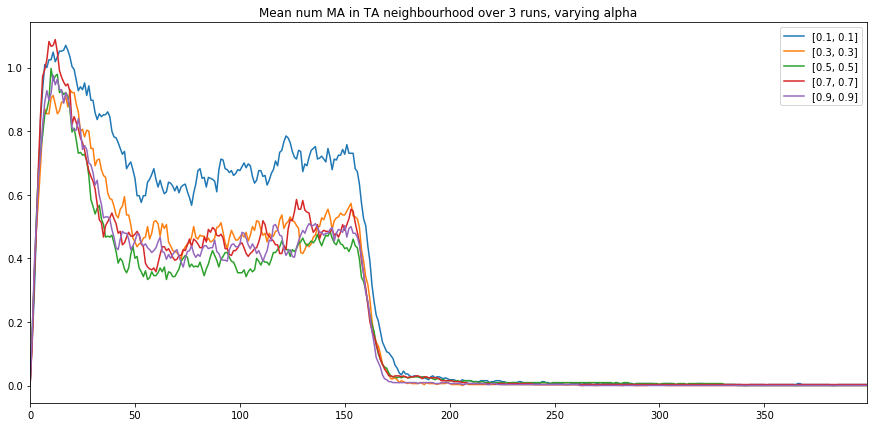

In [8]:
# Parse thorugh list end obtain interesting data then computes the mean and plots
#n_iters is defined above
n_ = len(alpha_vals)
dfsf = []
for i in range(len(tot_res)):
    for j in range(len(tot_res[0])):
        dfsf.append(pd.DataFrame(tot_res[i][j])['MA_in_TA_neigh'])
    
a1 = pd.DataFrame(dfsf).iloc[::n_] # selects 1 every 5 row which should have the same alphas values
a2 = pd.DataFrame(dfsf).iloc[1::n_]
a3 = pd.DataFrame(dfsf).iloc[2::n_]
a4 = pd.DataFrame(dfsf).iloc[3::n_]
a5 = pd.DataFrame(dfsf).iloc[4::n_]
pd.DataFrame([a1.mean(),a2.mean(),a3.mean(),a4.mean(),a5.mean()], index = [str(a) for a in alpha_vals]).T.plot(figsize = [15, 7],title = 'Mean num MA in TA neighbourhood over {} runs, varying alpha'.format(n_iters))

### Experiment 3: sensitivity on beta

In [20]:
N = 200
TAplusp = 0.15

fixed_params = {
                "N"       : N,
                "TAplusp" : TAplusp,
                "TAp"     : 0.15, # Exp 3 populations
                "MAp"     : .50,
                "NAp"     : .20,
                "d_alpha" : .2,  
                "w_alpha" : .2,
                #"d_beta"  : -.3,
                "w_beta"  : -.3,   
                "omega"   : .0,
                "OMEGA"  : -.97,
                "DT"      : .25,
                "heter_omegas": True,
                "omegas_var":.5,
                "omegas_mean":0.3
                #TAplus_TA_chars
               }

variable_params = {"d_beta":[.1,.3,.5,.7,.9]} 


n_iters = 3      

batch_run = BatchRunner(
    GameModel_extended,  
    variable_params, 
    fixed_params, 
    iterations=n_iters,   
    max_steps=401, 
    
    model_reporters={"Data Collector": lambda m: m.datacollector,
                     #"Avg_Neigh": avg_num_neighbours,
                     #"avg_TA_wealth": avg_TA_wealth,
                     #"avg_MA_wealth": avg_MA_wealth,
                     #"avg_NA_wealth":avg_NA_wealth,
                     #"Avg_TAp_wealth":avg_TAp_wealth,
                     #"Avg_TA_neigh":avg_num_neighbours_TA,
                     #"ACC_requests_TA":TA_acc_requests,
                     "Avg_TAp_neigh":avg_num_neighbours_TAplus,
                     #"avg_MA_in_TA_neigh":avg_MA_in_TA_neigh
                    }, 
    
    agent_reporters={"Wealth": 'wealth',
                     "Type":'type',
                     #"Neigh evo":'neigh_evo',
                     "MA_encoutered":"malicious_encountered"
                     #"Num_Trust_values":"len_DI_dict"
                    }
)

batch_run.run_all()  

15it [26:24, 105.64s/it]


In [21]:
batch_run.get_agent_vars_dataframe()

,d_beta,Run,AgentId,MA_encoutered,Type,Wealth,N,TAplusp,TAp,MAp,NAp,d_alpha,w_alpha,w_beta,omega,OMEGA,DT,heter_omegas,omegas_var,omegas_mean
0,0.1,0,0,0,TAplus,3569,200,0.15,0.15,0.5,0.2,0.2,0.2,-0.3,0.0,-0.97,0.25,True,0.5,0.3
127,0.1,0,127,100,MA,68714,200,0.15,0.15,0.5,0.2,0.2,0.2,-0.3,0.0,-0.97,0.25,True,0.5,0.3
128,0.1,0,128,95,MA,74058,200,0.15,0.15,0.5,0.2,0.2,0.2,-0.3,0.0,-0.97,0.25,True,0.5,0.3
129,0.1,0,129,98,MA,69775,200,0.15,0.15,0.5,0.2,0.2,0.2,-0.3,0.0,-0.97,0.25,True,0.5,0.3
130,0.1,0,130,97,MA,75990,200,0.15,0.15,0.5,0.2,0.2,0.2,-0.3,0.0,-0.97,0.25,True,0.5,0.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2869,0.9,14,69,96,MA,73023,200,0.15,0.15,0.5,0.2,0.2,0.2,-0.3,0.0,-0.97,0.25,True,0.5,0.3
2870,0.9,14,70,98,MA,75243,200,0.15,0.15,0.5,0.2,0.2,0.2,-0.3,0.0,-0.97,0.25,True,0.5,0.3
2871,0.9,14,71,101,MA,66645,200,0.15,0.15,0.5,0.2,0.2,0.2,-0.3,0.0,-0.97,0.25,True,0.5,0.3
2861,0.9,14,61,97,MA,66007,200,0.15,0.15,0.5,0.2,0.2,0.2,-0.3,0.0,-0.97,0.25,True,0.5,0.3


In [22]:
''' The average number of MA encountered  '''
agent_df = batch_run.get_agent_vars_dataframe()
agent_df['Num_Agents'] = 1
#agent_df = agent_df.assign(Num_Agents=1)
#num_agents = agent_df.groupby("Type").sum()["Num_Agents"].tolist()
agent_df = agent_df[["Type","Run","MA_encoutered", "d_alpha"]]
agent_df = agent_df[agent_df["Type"] == "TAplus"]
agent_df.groupby(["Run","Type"]).sum()/[0.15*N,30]

,,MA_encoutered,d_alpha
Run,Type,,
0,TAplus,5.100000,0.2
1,TAplus,0.000000,0.2
2,TAplus,5.033333,0.2
3,TAplus,8.133333,0.2
4,TAplus,7.700000,0.2
5,TAplus,4.700000,0.2
6,TAplus,3.433333,0.2
7,TAplus,5.933333,0.2
8,TAplus,3.400000,0.2


In [9]:
'''Unchanged paramenters for sensitivity'''
N            = 200       
N_steps      = 400 
TAplus_perc  = 0     
TA_perc      = 0.55  # Exp 2 populations
MA_perc      = 0.34  
NA_perc      = 0.11
alpha_vals    = [0.2, 0.2]   
DT           = 0.25                  
heter_omegas = True
omegas_mean  = .3
omegas_var   = 0.4
omega_vals   = [0.6, -0.6]# doesn't do anything if heter_omegas = Truedered trustworthy)

'''Varied param'''
beta_vals  = [[-0.1, -0.1],[-.3,-.3],[-.5,-.5],[-.7,-.7],[-.9,-.9]]      # values of alpha for DI and WI (must be > 0)
n_iters = 3  # how many iter for same beta val

''' RUN THE MODEL '''
tot_res = [] # store results

for i in range(n_iters):
    m_res = []
    for b in beta_vals:
        model = GameModel_extended(N, TAplus_perc, TA_perc, MA_perc, NA_perc, alpha_vals[0], alpha_vals[1], 
                                   b[0], b[1],    #Changes
                                   omega_vals[0], omega_vals[1],DT, heter_omegas, omegas_mean, omegas_var) 

        for i in range(N_steps):                                 
            model.step()

        m_res.append(model.datacollector.get_model_vars_dataframe())
    tot_res.append(m_res)

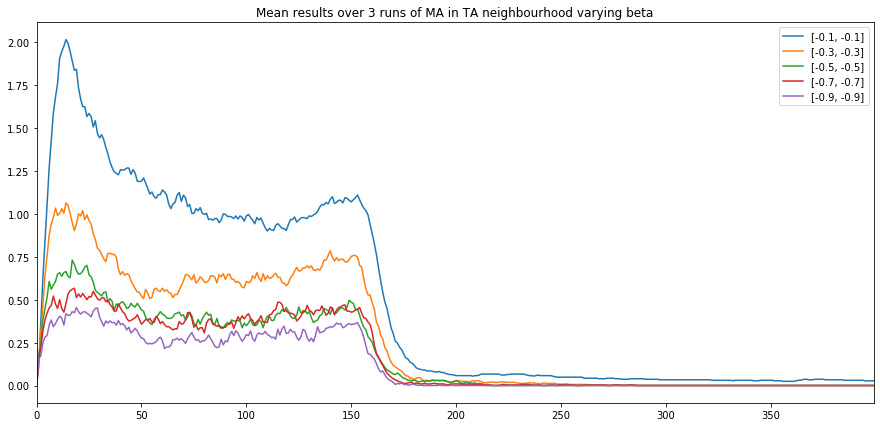

In [10]:
# Parse thorugh list end obtain interesting data then computes the mean and plots
'''For beta'''
#n_iters is defined above
n_ = len(beta_vals)
dfsf = []
for i in range(len(tot_res)):
    for j in range(len(tot_res[0])):
        dfsf.append(pd.DataFrame(tot_res[i][j])['MA_in_TA_neigh'])
    
a1 = pd.DataFrame(dfsf).iloc[::n_] # selects 1 every 5 row which should have the same alphas values
a2 = pd.DataFrame(dfsf).iloc[1::n_]
a3 = pd.DataFrame(dfsf).iloc[2::n_]
a4 = pd.DataFrame(dfsf).iloc[3::n_]
a5 = pd.DataFrame(dfsf).iloc[4::n_]
pd.DataFrame([a1.mean(),a2.mean(),a3.mean(),a4.mean(),a5.mean()], index = [str(a) for a in beta_vals]).T.plot(figsize = [15, 7], title = 'Mean results over {} runs of MA in TA neighbourhood varying beta'.format(n_iters))

## Experiment 4 sensitivity

As for experiment 4, we noted that it is pretty stochastic just by re-running it several times. 
Thus, we don't find worthy to show much about sensitivity here, the relevant things are that:
- the higher is the willingness to observe, the more deterministic it can become, and the more TA+ are put in an advantagious position. 
- if there are no Super-Trusters, TAp are usually able to avoid at all contact with MA, although it generally takes them around 300-350 steps to buld relations with other agents, contrarily to the particular run obtained here

### Experiment 4 with no Super-Trusters

In [15]:
''' MODEL PARAMETERS '''
N = 200       # num agents
N_steps = 400 # num steps

# agent type distribution
TAplus_perc = 0.1     # % of Trust-Aware-plus we want
TA_perc     = 0.1  # % of Trust-Aware we want
MA_perc     = 0.4 # % of Malicious we want
NA_perc     = 1 - MA_perc - TA_perc - TAplus_perc    # % of Naive we want

''' AGENT PARAMETERS '''
alpha_vals = [0.2, 0.2]       # values of alpha for DI and WI (must be > 0)
beta_vals  = [-0.3, -0.3]     # values of beta for DI and WI  (must be < 0)
omega_vals = [0.6, -0.6]      # values of omega (upper threshold; between -1 and 1) and OMEGA (between -1 and 1; if DI trust > omega, agent is considered trustworthy)
DT = 0.25                     # threshold relevant for WI decision rule, set to 0.25 in the paper
obs_prob = 0.001              # probability of observing a single interaction, computed at each time-step for every interaction
            
TAplus_TA_chars = [['TAplus', 5, "TTFT", "Ho", "Mo", "Th+", obs_prob], ['TA', 5, "TTFT", "Ho", "Mo", "Ca", 0]]
          

''' RUN THE MODEL '''
model = GameModel_extended(N,                                     # <--- intitialize the model
                  TAplus_perc, TA_perc, MA_perc, NA_perc,
                  alpha_vals[0], alpha_vals[1],
                  beta_vals[0], beta_vals[1],
                  omega_vals[0], omega_vals[1],
                  DT,
                  False,0,0,
                  TAplus_TA_chars        
                 )

for i in range(N_steps):                                 # <--- Run the model for N_steps steps
    model.step()

In [16]:
''' Get the average number of MA encountered by each agent_type '''
agent_df = model.datacollector.get_agent_vars_dataframe()
agent_df['Num_Agents'] = 1
#agent_df = agent_df.assign(Num_Agents=1)
num_agents = agent_df.xs(N_steps-1, level="Step").groupby("Type").sum()["Num_Agents"].tolist()
agent_df.xs(N_steps-1, level="Step").groupby("Type").sum()/[1,num_agents,1,1]

,Wealth,MA_encoutered,Num_Trust_values,Num_Agents
Type,,,,
MA,7691453.0,105.575,8908.0,80.0
NA,1077909.0,37.950,4273.0,80.0
TA,220720.0,33.700,917.0,20.0
TAplus,138185.0,0.000,206.0,20.0


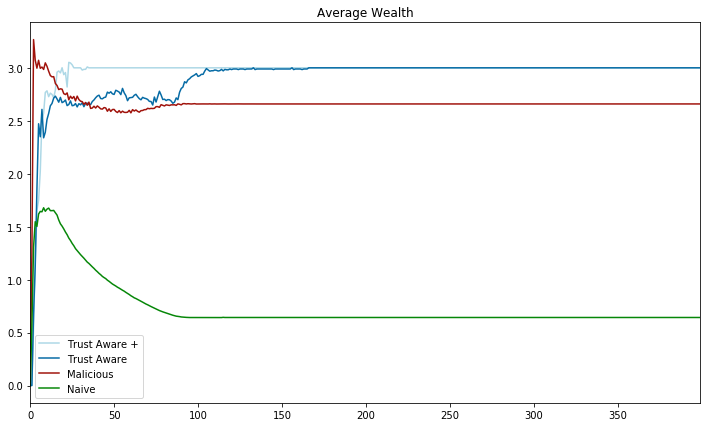

In [17]:
model_df = model.datacollector.get_model_vars_dataframe()[["Avg_TAp_wealth","avg_TA_wealth", "avg_MA_wealth", "avg_NA_wealth"]]
model_df.columns=["Trust Aware +", "Trust Aware", "Malicious", "Naive"]
matplotlib.rcParams['figure.figsize']= [12,7]
model_df.plot(color = ['lightblue', '#066BA5','#A0120B','#068708'], title = "Average Wealth")

# BATCH RUN TEMPLATE
This can be used to produce network images for an experiment, varying some parameters.

We how how the network structure changes in experiment 1 by changing omegas

In [16]:
# 1 . define the parameters that we want to keep fixed for each experiment
fixed_params = {
                "N"       : 200,
                "TAplusp" : 0,
                "TAp"     : .66, #Exp 1 populations
                "MAp"     : .34,
                "NAp"     : 0,
                "d_alpha" : .2,  
                "w_alpha" : .2,
                #"d_beta"  : -.3,
                "w_beta"  : -.3,   
                "omega"   : .0,
                "OMEGA"  : -.97,
                "DT"      : .25,
                "heter_omegas": True,
                "omegas_mean":.3,
                "omegas_var":.4,
                #TAplus_TA_chars
               }


# 2 . define the parameters that we want to test, that is we want to change them in different experiments
variable_params = {
                   #"d_alpha" : np.arange(0.1, 1, 0.2),  
                   #"w_alpha" : np.arange(.1, 0.5, 0.1),
                   "d_beta"  : [0, -0.1, -0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9]
                   #"w_beta"  : np.arange(-.5, -.1, 0.1),   
                   #"omega"    : np.arange(-1, .1, 0.2),  
                   #"OMEGA"    : np.arange(-0.2, 1.01, 0.2),
                   #"DT"      : np.arange(0.15,0.45,.05),
                   #"heter_omegas": True,
                   #"omegas_mean":[.1,.3,.5,.7,.9],
                   #"omegas_var":[.1,.3,.4,.5],
                  } 


    

# 3. initialize the BatchRunner
batch_run = BatchRunner(
    GameModel_extended,  
    variable_params, 
    fixed_params, 
    iterations= 1,  # CAREFUL HERE
    max_steps=401,  # AND HERE
    
    model_reporters={
                     "Data Collector": lambda m: m.datacollector,
                     "Avg_Neigh": avg_num_neighbours,
                     "avg_TA_wealth": avg_TA_wealth,
                     "avg_MA_wealth": avg_MA_wealth,
                     "avg_NA_wealth":avg_NA_wealth,
                     "Avg_TAp_wealth":avg_TAp_wealth,
                     "Avg_TA_neigh":avg_num_neighbours_TA,
                     "ACC_requests_TA":TA_acc_requests,
                     "Avg_TAp_neigh":avg_num_neighbours_TAplus,
                     "avg_MA_in_TA_neigh":avg_MA_in_TA_neigh
                    }, 
    
    agent_reporters={
                     "Wealth": 'wealth',
                     "Type":'type',
                     "Neigh evo":'neigh_evo',
                     "MA_encoutered":"malicious_encountered",
                     "Num_Trust_values":"len_DI_dict"
                    }
)

# 4. Run the experiments
batch_run.run_all()  

10it [09:12, 55.27s/it]


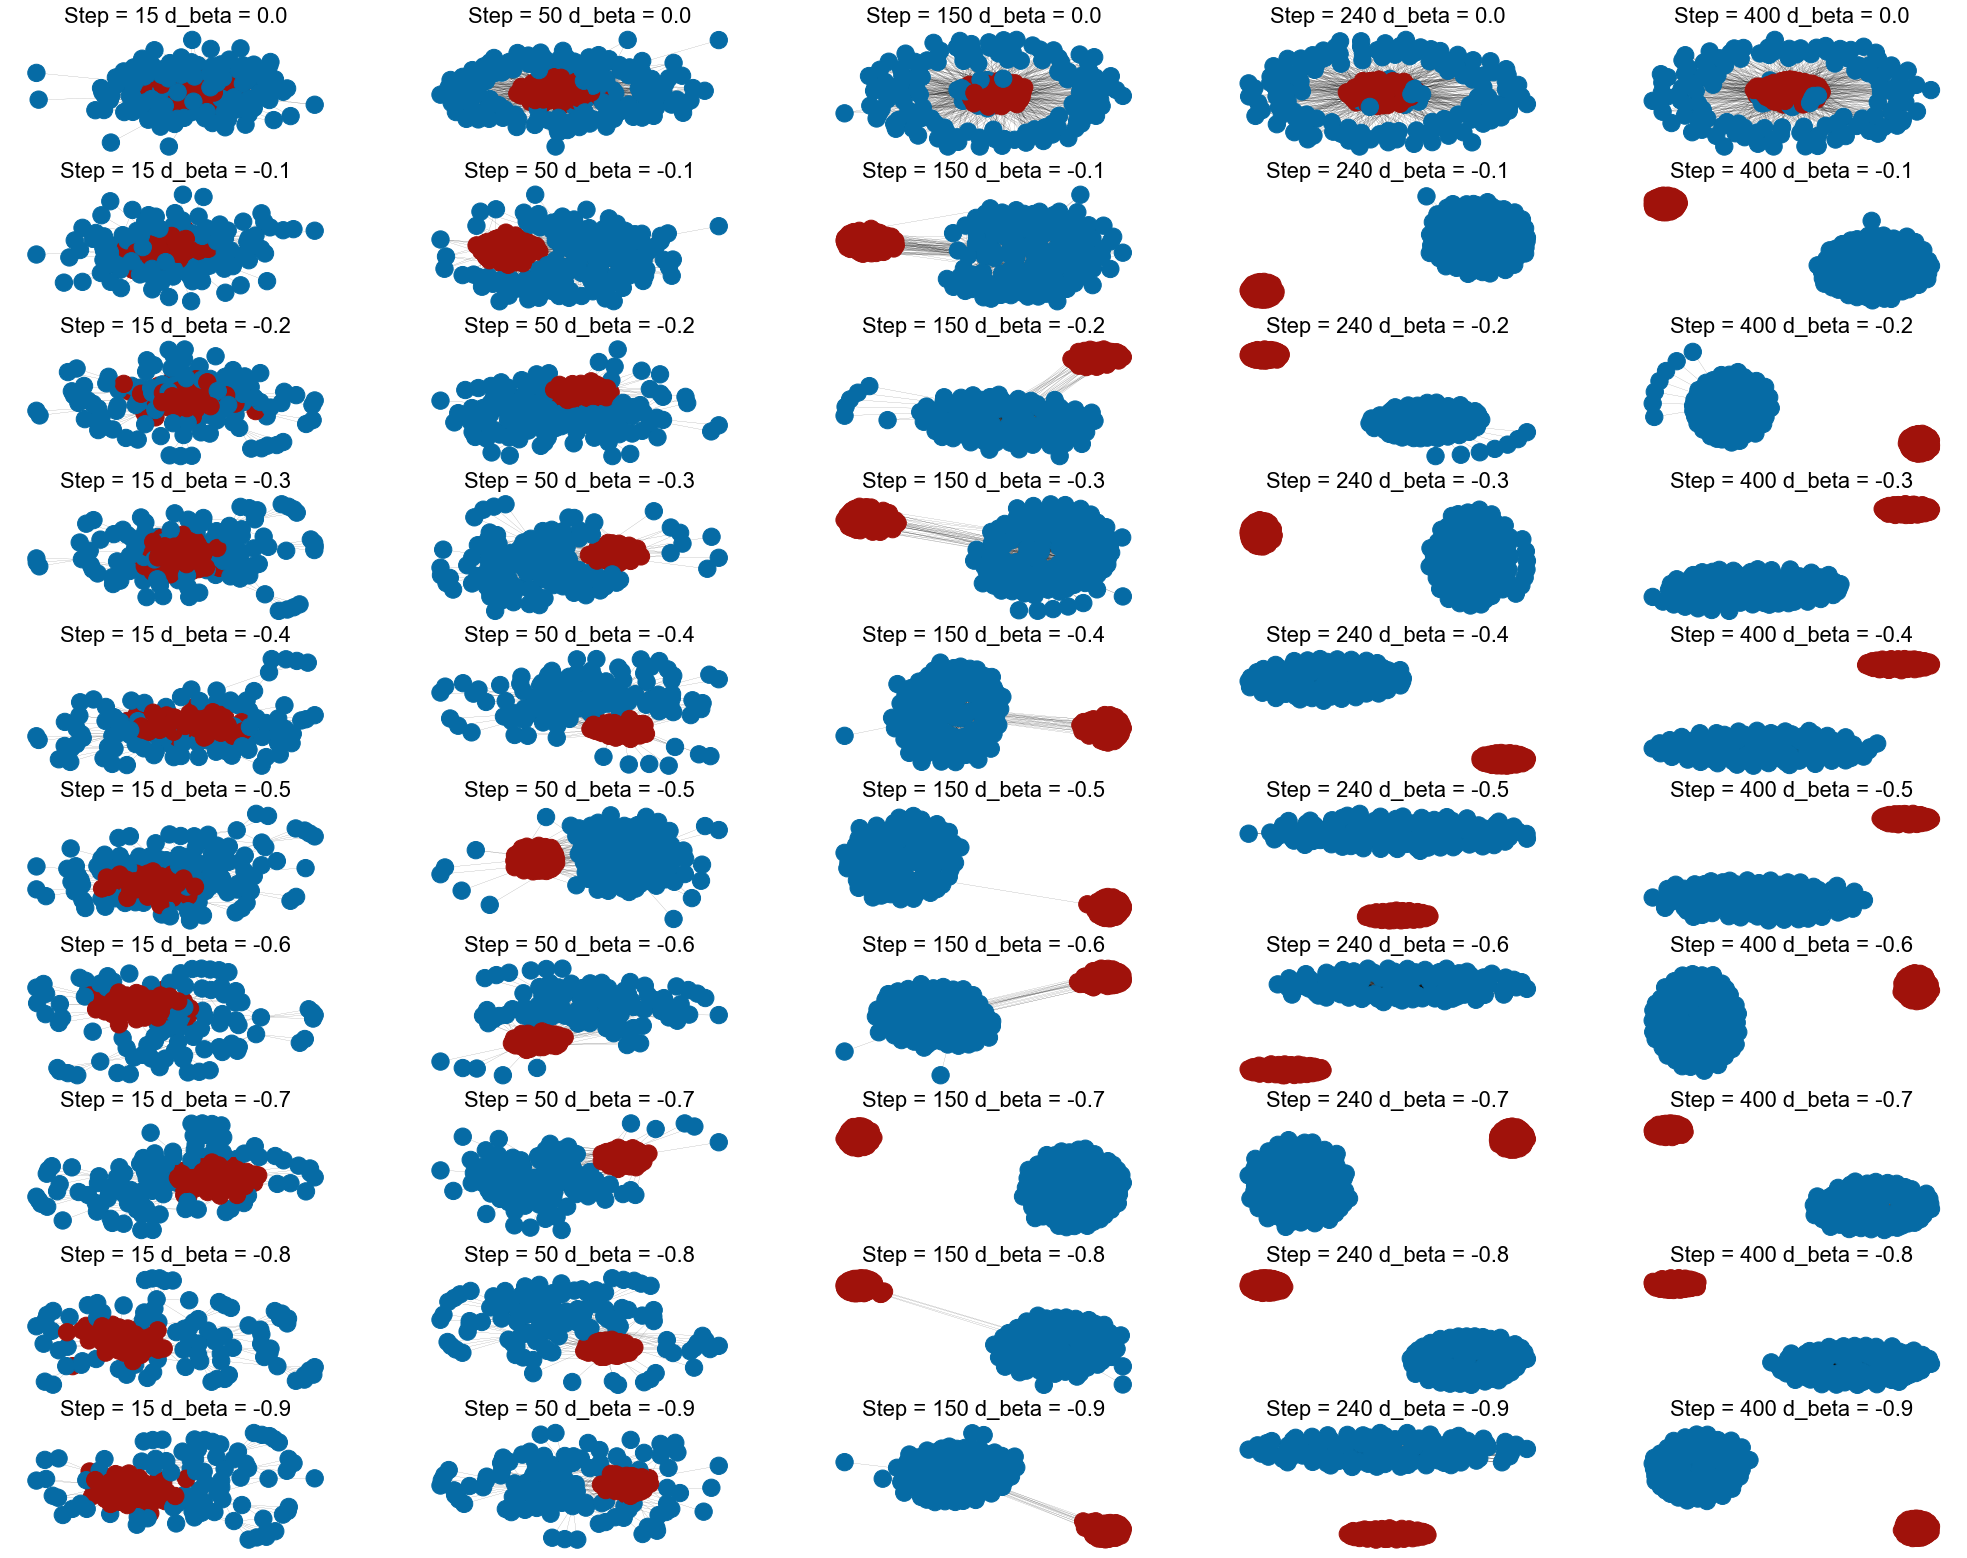

In [17]:
############################################
'''plotting networks at interesting steps'''  # Need to input only 1 variable parameter with range
############################################
'''!!!DOESN'T WORK WITH MULTIPLE ITERS!!!'''  # use only 1 in n_iters
############################################


steps_of_interest = [15,50,150,240,400] # Steps to look at, can be any length (but 5 is already a lot)
                                               # (N_steps-1) might error, just manually input 399/400
                                              
batch_agents = batch_run.get_agent_vars_dataframe() # The sorting of ids is done inside the which_steps function

#remember to run 'fuctions to anlyze results' cell for this next command to work
df_edge = which_steps(batch_agents, steps_of_interest) # dataframe with edges 


param_vals = df_edge[df_edge.columns[0]].unique() # store parameters values to iterate over (in this case OMEGA)

#print(param_vals)

''' associate each agent_type to a color '''
dict_ids_type = {df_edge.AgentId[i]:('#A0120B' if df_edge.Type[i]=="MA" 
                                          else '#068708' if df_edge.Type[i]=="NA" 
                                          else '#066BA5' if df_edge.Type[i]=="TA"
                                          else 'lightblue') for i in range(len(df_edge))}


# This doesn't really work right now, needs adjusted values for other vars than OMEGA
matplotlib.rcParams['figure.figsize']= [35, 28]

c = 1
for i in param_vals:
    for step in steps_of_interest:
        # next code line looks ugly just because i wanted to make it more general
        G = create_graph(df_edge[df_edge[df_edge.columns[0]] == i]['{}'.format(step)].tolist(),dict_ids_type)
        
        # plot params
        pos = nx.spring_layout(G)
        plt.subplot(len(param_vals), len(steps_of_interest), c)
        c += 1 #to update index for next graph
        
        #plots appear
        graph_plot(G,pos, title = 'Step = {} {} = {}'.format(step,str(batch_agents.columns[0]),round(i,2)), width = 0.1)